<a href="https://colab.research.google.com/github/Ivy1093367/Boyandgirl_predict/blob/main/Y2Chen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 環境設定&資料集匯入**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
corpus_root = 'drive/My Drive/Colab Notebooks/datasets/'

In [3]:
train_df = pd.read_csv(corpus_root+'boygirltrain.csv')
test_df = pd.read_csv(corpus_root+'boygirltest.csv')

In [4]:
train_df

,id,gender,star_sign,phone_os,height,weight,sleepiness,iq,fb_friends,yt,self_intro
0,1,2,處女座,Apple,154.0,43.0,NaN,NaN,583.0,0,Beautiful
1,2,2,處女座,Apple,156.0,47.0,NaN,130.0,NaN,3.5,Enjoying being who I'm notsss
2,3,1,射手座,NaN,170.0,61.0,NaN,90.0,540.0,NaN,Practice Makes perfect
3,4,1,射手座,Apple,170.0,62.0,4.0,100.0,NaN,5,Straightforward
4,5,2,射手座,Android,158.0,67.0,NaN,128.0,320.0,1.2,Humorous
...,...,...,...,...,...,...,...,...,...,...,...
418,419,1,處女座,Android,166.0,66.0,4.0,90.0,1000.0,1,I hope i am a super hero.
419,420,1,牡羊座,Android,176.0,65.0,4.0,87.0,1300.0,2,NaN
420,421,1,NaN,Apple,174.0,72.0,2.0,NaN,2000.0,9,NaN
421,422,2,天蠍座,NaN,167.0,50.0,3.0,180.0,483.0,10,NaN


In [5]:
test_df

,id,gender,star_sign,phone_os,height,weight,sleepiness,iq,fb_friends,yt,self_intro
0,1,0,天蠍座,Apple,200.0,100.0,1.0,87.0,87.0,87.0,GOod
1,2,0,金牛座,Apple,175.0,80.0,3.0,NaN,2000.0,NaN,Easygoing
2,3,0,雙子座,Apple,155.0,45.0,3.0,150.0,NaN,9.0,NaN
3,4,0,處女座,Apple,173.0,85.0,4.0,NaN,NaN,15.0,NaN
4,5,0,射手座,Android,164.0,57.0,4.0,130.0,505.0,2.0,I'm smart
...,...,...,...,...,...,...,...,...,...,...,...
421,422,0,金牛座,Apple,160.0,70.0,4.0,NaN,500.0,5.0,I am a girl.
422,423,0,天蠍座,Android,162.0,54.0,3.0,180.0,462.0,5.0,NaN
423,424,0,天蠍座,Apple,173.0,66.0,NaN,135.0,102.0,11.1,I like to play basketball.
424,425,0,NaN,NaN,165.0,53.0,NaN,110.0,507.0,416.0,Good


In [6]:
train_df.isnull().sum()

,0
id,0
gender,0
star_sign,86
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,90


# **2.資料前處理**






<h2>2.1 缺失比例查看

In [7]:
# 定義數據清理函數
def clean_data(X, reference_df=None):
    X_clean = X.copy()
    for col in X_clean.columns:
        X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')  # 轉為數值，無效值變 NaN
        fill_value = reference_df[col].median() if reference_df is not None else X_clean[col].median()
        X_clean[col] = X_clean[col].replace([np.inf, -np.inf], np.nan).fillna(fill_value)
        X_clean[col] = X_clean[col].clip(lower=-1e38, upper=1e38)  # 限制值範圍
    return X_clean

In [8]:
def check_missing_proportions(df, name="Data"):
    print(f"\n {name} 缺失比例：")
    missing_ratio = df.isnull().mean()  # 每個變數的缺失比例
    overall_missing_ratio = df.isnull().mean().mean()  # 整體缺失比例
    print(missing_ratio)
    print(f"\n整體缺失比例: {overall_missing_ratio:.2%}")

check_missing_proportions(train_df, "訓練集")
check_missing_proportions(test_df, "測試集")


 訓練集 缺失比例：
id            0.000000
gender        0.000000
star_sign     0.203310
phone_os      0.184397
height        0.174941
weight        0.200946
sleepiness    0.215130
iq            0.186761
fb_friends    0.182033
yt            0.212766
self_intro    0.245863
dtype: float64

整體缺失比例: 16.42%

 測試集 缺失比例：
id            0.000000
gender        0.000000
star_sign     0.190141
phone_os      0.225352
height        0.159624
weight        0.225352
sleepiness    0.169014
iq            0.215962
fb_friends    0.206573
yt            0.183099
self_intro    0.218310
dtype: float64

整體缺失比例: 16.30%


<h2>2.2 刪除欄位

In [9]:
id_train_backup = train_df['id'].copy()
id_test_backup = test_df['id'].copy()

train_df.drop(columns=["star_sign"], inplace=True)
test_df.drop(columns=["star_sign"], inplace=True)

train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)

self_train_backup = train_df['self_intro'].copy()
self_test_backup = test_df['self_intro'].copy()

train_df = train_df.drop(columns=['self_intro'])
test_df = test_df.drop(columns=['self_intro'])

<h2>2.3 處理特殊值



In [10]:
cat_cols = ["phone_os", "sleepiness"]

In [11]:
import numpy as np
missing_values = ['', 'N/A', 'missing', '#NUM!']

train_df = train_df.replace(missing_values, np.nan)

train_df['yt'] = pd.to_numeric(train_df['yt'], errors='coerce')
test_df['yt'] = pd.to_numeric(test_df['yt'], errors='coerce')

In [12]:
train_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt
0,2,Apple,154.0,43.0,NaN,NaN,583.0,0.0
1,2,Apple,156.0,47.0,NaN,130.0,NaN,3.5
2,1,NaN,170.0,61.0,NaN,90.0,540.0,NaN
3,1,Apple,170.0,62.0,4.0,100.0,NaN,5.0
4,2,Android,158.0,67.0,NaN,128.0,320.0,1.2
...,...,...,...,...,...,...,...,...
418,1,Android,166.0,66.0,4.0,90.0,1000.0,1.0
419,1,Android,176.0,65.0,4.0,87.0,1300.0,2.0
420,1,Apple,174.0,72.0,2.0,NaN,2000.0,9.0
421,2,NaN,167.0,50.0,3.0,180.0,483.0,10.0


In [13]:
test_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt
0,0,Apple,200.0,100.0,1.0,87.0,87.0,87.0
1,0,Apple,175.0,80.0,3.0,NaN,2000.0,NaN
2,0,Apple,155.0,45.0,3.0,150.0,NaN,9.0
3,0,Apple,173.0,85.0,4.0,NaN,NaN,15.0
4,0,Android,164.0,57.0,4.0,130.0,505.0,2.0
...,...,...,...,...,...,...,...,...
421,0,Apple,160.0,70.0,4.0,NaN,500.0,5.0
422,0,Android,162.0,54.0,3.0,180.0,462.0,5.0
423,0,Apple,173.0,66.0,NaN,135.0,102.0,11.1
424,0,NaN,165.0,53.0,NaN,110.0,507.0,416.0


In [14]:
print(train_df['gender'].unique())

[2 1]


<h2>2.4 檢查fb的資料分布

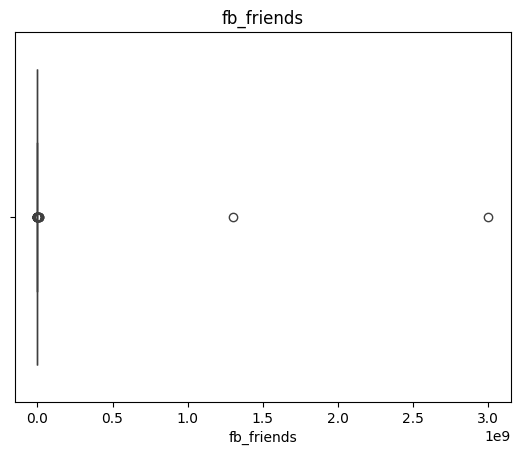

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=train_df['fb_friends'])
plt.title("fb_friends")
plt.show()

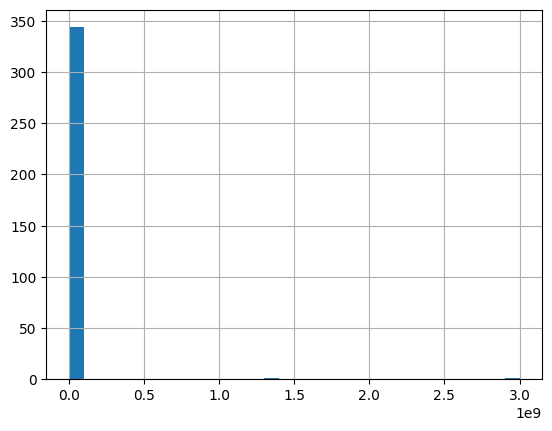

In [16]:
train_df['fb_friends'].hist(bins=30)
plt.show()

In [17]:
train_df.loc[train_df['fb_friends'] < 0, 'fb_friends'] *= -1
test_df.loc[test_df['fb_friends'] < 0, 'fb_friends'] *= -1

In [18]:
def process_fb_friends_mobile_traffic(df, upper_limit=3000):
    df = df.copy()
    df['is_outlier_fb_friends'] = df['fb_friends'] >= upper_limit
    df['fb_friends'] = df['fb_friends'].clip(upper=upper_limit)
    return df

train_df = process_fb_friends_mobile_traffic(train_df)
test_df = process_fb_friends_mobile_traffic(test_df)

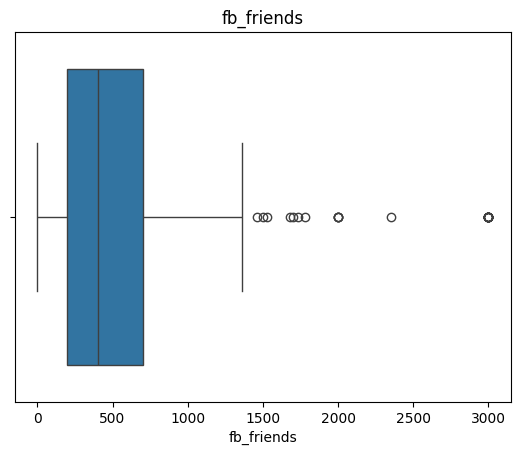

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.boxplot(x=train_df['fb_friends'])
plt.title("fb_friends")
plt.show()

In [20]:
train_df.isnull().sum()

,0
gender,0
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,91
is_outlier_fb_friends,0


<h2>2.5 檢查yt資料分布

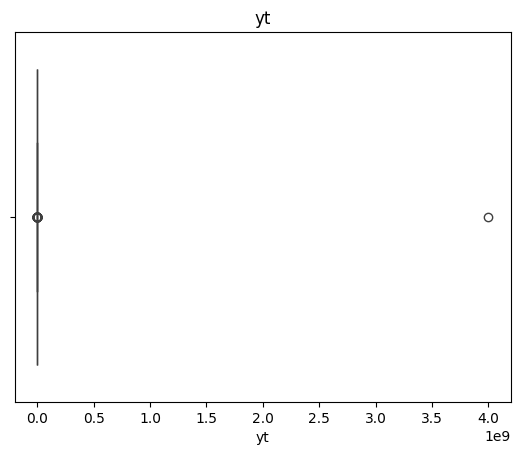

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=train_df['yt'])
plt.title("yt")
plt.show()

In [22]:
train_df.loc[train_df['yt'] < 0, 'yt'] *= -1
test_df.loc[test_df['yt'] < 0, 'yt'] *= -1

In [23]:
def process_yt_mobile_traffic(df, upper_limit=500):
    df = df.copy()
    df['is_outlier_yt'] = df['yt'] >= upper_limit
    df['yt'] = df['yt'].clip(upper=upper_limit)
    return df

train_df = process_yt_mobile_traffic(train_df)
test_df = process_yt_mobile_traffic(test_df)

In [24]:
train_df.isnull().sum()

,0
gender,0
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,91
is_outlier_fb_friends,0
is_outlier_yt,0


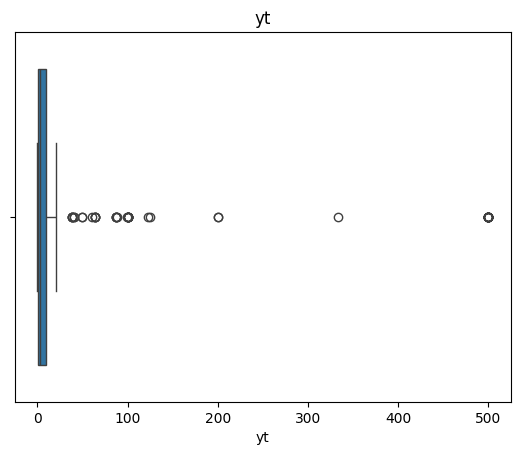

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=train_df['yt'])
plt.title("yt")
plt.show()

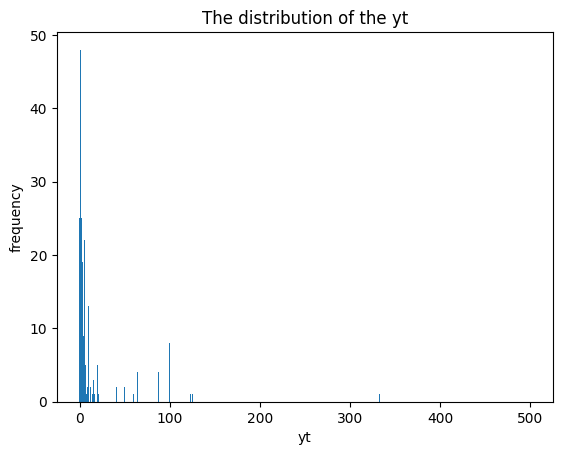

In [26]:
sleepiness_values = train_df['yt'].unique()

# 計算每個yt的出現次數
value_counts = train_df['yt'].value_counts()

# 重新索引value_counts，確保所有unique_values都包含在內，缺少的值填入 0
value_counts = value_counts.reindex(sleepiness_values, fill_value = 0)

plt.bar(sleepiness_values, value_counts)
plt.xlabel('yt')
plt.ylabel('frequency')
plt.title('The distribution of the yt')
plt.show()

<h2>2.6檢查height分布




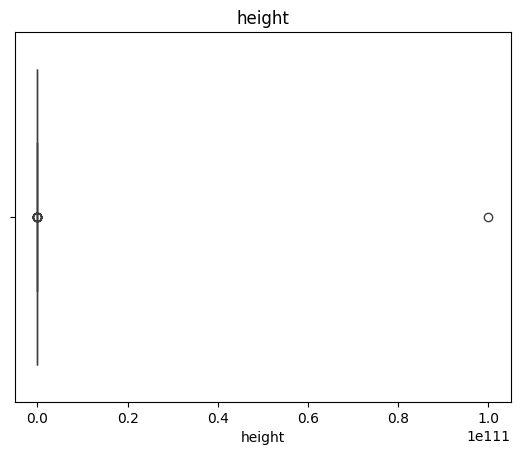

In [27]:
sns.boxplot(x=train_df['height'])
plt.title("height")
plt.show()

In [28]:
train_df.loc[train_df['height'] < 130, 'height'] = 140
test_df.loc[test_df['height'] < 130, 'height'] = 140

In [29]:
def process_height_mobile_traffic(df, upper_limit=200):
    df = df.copy()
    df['is_outlier_height'] = df['height'] >= upper_limit
    df['height'] = df['height'].clip(upper=upper_limit)
    return df

train_df = process_height_mobile_traffic(train_df)
test_df = process_height_mobile_traffic(test_df)

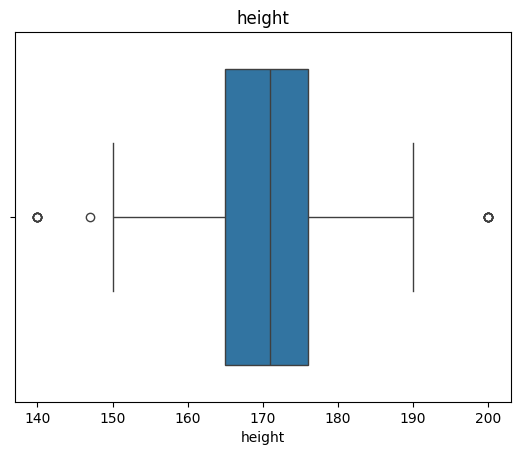

In [30]:
sns.boxplot(x=train_df['height'])
plt.title("height")
plt.show()

In [31]:
train_df.isnull().sum()

,0
gender,0
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,91
is_outlier_fb_friends,0
is_outlier_yt,0


<h2>2.7檢查weight分布

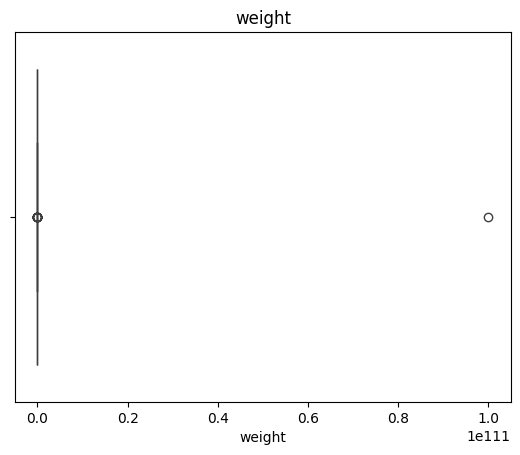

In [32]:
sns.boxplot(x=train_df['weight'])
plt.title("weight")
plt.show()

In [33]:
train_df.loc[(train_df['weight'] < 30), 'weight'] = 40
test_df.loc[(test_df['weight'] < 30), 'weight'] = 40

In [34]:
def process_weight_mobile_traffic(df, upper_limit=130):
    df = df.copy()
    df['is_outlier_weight'] = df['weight'] >= upper_limit
    df['weight'] = df['weight'].clip(upper=upper_limit)
    return df

train_df = process_weight_mobile_traffic(train_df)
test_df = process_weight_mobile_traffic(test_df)

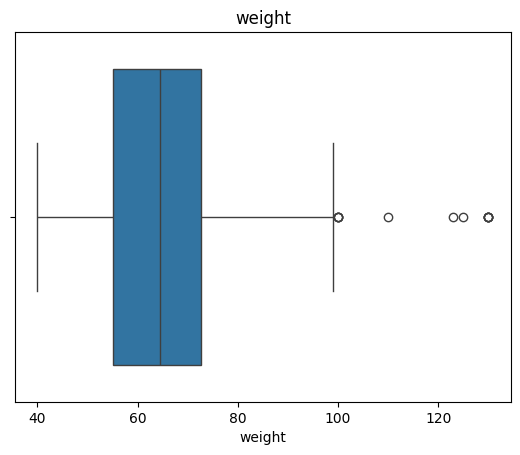

In [35]:
sns.boxplot(x=train_df['weight'])
plt.title("weight")
plt.show()

In [36]:
train_df.isnull().sum()

,0
gender,0
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,91
is_outlier_fb_friends,0
is_outlier_yt,0


<h2>2.8檢查IQ分布

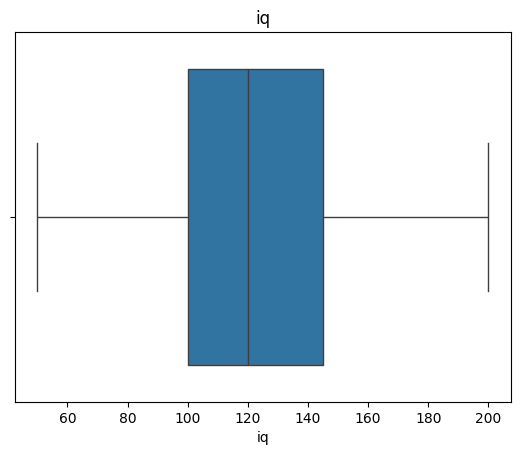

In [37]:
sns.boxplot(x=train_df['iq'])
plt.title("iq")
plt.show()

<h2>2.9檢查sleepiness分布

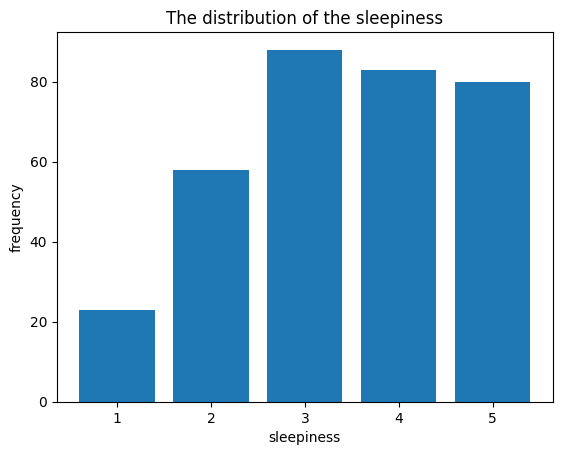

In [38]:
sleepiness_values = train_df['sleepiness'].unique()

# 計算每個sleepiness的出現次數
value_counts = train_df['sleepiness'].value_counts()

# 重新索引value_counts，確保所有unique_values都包含在內，缺少的值填入 0
value_counts = value_counts.reindex(sleepiness_values, fill_value = 0)

plt.bar(sleepiness_values, value_counts)
plt.xlabel('sleepiness')
plt.ylabel('frequency')
plt.title('The distribution of the sleepiness')
plt.show()

<h2>2.10 標記train離群值欄位

In [39]:
def mark_outliers_iqr(df, columns, k=1.5):
    df_marked = df.copy()

    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - k * IQR
            upper = Q3 + k * IQR

            df_marked[f'is_outlier_{col}'] = ~df[col].between(lower, upper)
            outlier_count = df_marked[f'is_outlier_{col}'].sum()
            print(f" {col}: 已標記 {outlier_count} 筆離群值（不在 [{round(lower,2)}, {round(upper,2)}] 內）")

    return df_marked

In [40]:
# 要標記的欄位
target_columns = ['height', 'weight', 'iq', 'fb_friends', 'yt']
# 執行標記
train_df = mark_outliers_iqr(train_df, columns=target_columns)

 height: 已標記 88 筆離群值（不在 [148.5, 192.5] 內）
 weight: 已標記 97 筆離群值（不在 [28.38, 99.38] 內）
 iq: 已標記 79 筆離群值（不在 [32.5, 212.5] 內）
 fb_friends: 已標記 105 筆離群值（不在 [-550.0, 1450.0] 內）
 yt: 已標記 146 筆離群值（不在 [-12.5, 23.5] 內）


<h2>2.11 標記test離群值

In [41]:
def mark_outliers_by_reference(df_target, df_reference, columns, k=1.5):
    df_marked = df_target.copy()

    for col in columns:
        if pd.api.types.is_numeric_dtype(df_reference[col]):
            Q1 = df_reference[col].quantile(0.25)
            Q3 = df_reference[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - k * IQR
            upper = Q3 + k * IQR

            df_marked[f'is_outlier_{col}'] = ~df_target[col].between(lower, upper)
            outlier_count = df_marked[f'is_outlier_{col}'].sum()
            print(f"【{col}】在 test 中標記 {outlier_count} 筆離群值（不在 [{round(lower,2)}, {round(upper,2)}] 內）")

    return df_marked

In [42]:
test_df = mark_outliers_by_reference(test_df, train_df, columns=target_columns)

【height】在 test 中標記 82 筆離群值（不在 [148.5, 192.5] 內）
【weight】在 test 中標記 105 筆離群值（不在 [28.38, 99.38] 內）
【iq】在 test 中標記 92 筆離群值（不在 [32.5, 212.5] 內）
【fb_friends】在 test 中標記 105 筆離群值（不在 [-550.0, 1450.0] 內）
【yt】在 test 中標記 200 筆離群值（不在 [-12.5, 23.5] 內）


In [43]:
# 讓test_df排成跟train_df一樣的欄位順序
column_order = train_df.columns.tolist()
test_df = test_df.loc[:, column_order]

**Label encoding**

In [44]:
print(train_df['phone_os'].unique())

['Apple' nan 'Android' 'Windows Phone' 'JohnCena']


In [45]:
import numpy as np
import pandas as pd
import re

def preprocess_and_encode(train_df, test_df):
    # 合併 train 和 test 保證編碼一致
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    def clean_os(x):
        if isinstance(x, str):
            x = re.sub(r'[^\w]', '', x)  # 移除非字母數字的符號
            x = x.strip().lower()        # 去空白 + 小寫
            return x
        return np.nan

    combined_df['phone_os'] = combined_df['phone_os'].apply(clean_os)

    # 動態建構 label encoder
    label_dict = {}
    label_counter = 0

    def get_label(x):
        nonlocal label_counter
        if pd.isna(x):
            return np.nan
        if x not in label_dict:
            label_dict[x] = label_counter
            label_counter += 1
        return label_dict[x]

    combined_df['phone_os_encoded'] = combined_df['phone_os'].apply(get_label)

    # 分回 train, test
    train_df['phone_os'] = combined_df.loc[:len(train_df) - 1, 'phone_os_encoded'].values
    test_df['phone_os'] = combined_df.loc[len(train_df):, 'phone_os_encoded'].values

    print("編碼對應表：", label_dict)
    return train_df, test_df, label_dict

train_df, test_df, label_dict = preprocess_and_encode(train_df, test_df)

print(train_df.head())
print(test_df.head())

編碼對應表： {'apple': 0, 'android': 1, 'windowsphone': 2, 'johncena': 3, 'linux': 4}
   gender  phone_os  height  weight  sleepiness     iq  fb_friends   yt  \
0       2       0.0   154.0    43.0         NaN    NaN       583.0  0.0   
1       2       0.0   156.0    47.0         NaN  130.0         NaN  3.5   
2       1       NaN   170.0    61.0         NaN   90.0       540.0  NaN   
3       1       0.0   170.0    62.0         4.0  100.0         NaN  5.0   
4       2       1.0   158.0    67.0         NaN  128.0       320.0  1.2   

   is_outlier_fb_friends  is_outlier_yt  is_outlier_height  is_outlier_weight  \
0                  False          False              False              False   
1                   True          False              False              False   
2                  False           True              False              False   
3                   True          False              False              False   
4                  False          False              False      

In [46]:
# 抓出含有'is_outlier'的欄位
outlier_cols = [col for col in train_df.columns if 'is_outlier' in col]

# 對這些欄位做 label encoding
for col in outlier_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

# **3. 缺失值處理**


## 3.0 定義參數

In [47]:
train_df_before = train_df
test_df_before = test_df
test_df['gender'] = np.nan

In [48]:
train_df.isnull().sum()

,0
gender,0
phone_os,78
height,74
weight,85
sleepiness,91
iq,79
fb_friends,77
yt,91
is_outlier_fb_friends,0
is_outlier_yt,0


In [49]:
import pandas as pd

def check_missing_proportions(df, name="Data"):
    print(f"\n {name} 缺失比例報告：")

    missing_count = df.isnull().sum()
    missing_ratio = df.isnull().mean() * 100

    # 組成 DataFrame 並排序
    result = pd.DataFrame({
        "Missing Count": missing_count,
        "Missing Rate (%)": missing_ratio.round(2)
    })
    result = result[result["Missing Count"] > 0].sort_values("Missing Rate (%)", ascending=False)

    if result.empty:
        print("無任何缺失值！")
    else:
        display(result)

    overall_ratio = df.isnull().values.sum() / df.size
    print(f"\n整體缺失比例: {overall_ratio:.2%}")
check_missing_proportions(train_df, "訓練集")
check_missing_proportions(test_df, "測試集")



 訓練集 缺失比例報告：


,Missing Count,Missing Rate (%)
sleepiness,91,21.51
yt,91,21.51
weight,85,20.09
iq,79,18.68
phone_os,78,18.44
fb_friends,77,18.20
height,74,17.49



整體缺失比例: 10.46%

 測試集 缺失比例報告：


,Missing Count,Missing Rate (%)
gender,426,100.00
phone_os,96,22.54
weight,96,22.54
iq,92,21.60
fb_friends,88,20.66
yt,78,18.31
sleepiness,72,16.90
height,68,15.96



整體缺失比例: 18.35%


<Axes: >

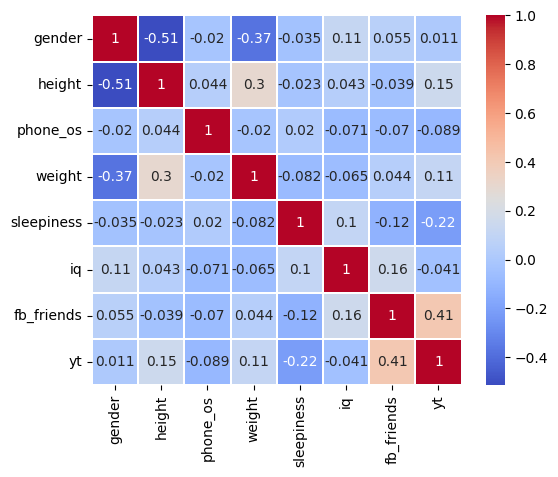

In [50]:
# 數值欄位相關性
#負擔（負擔相關）：表示兩個變數的逆轉變化（例如性別增加，身高減少）。
#正數（正相關）：表示兩個變化數同向變化（例如身高增加，體重增加）。
sns.heatmap(train_df[['gender', 'height', 'phone_os', 'weight', 'sleepiness', 'iq', 'fb_friends', 'yt']].corr(),linewidths=0.1,vmax=1.0,cmap="coolwarm" , square=True,linecolor='white', annot=True)

## 3.1插補模型function

**DT+KNN**

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer

def dt_impute_classifier(train_df, test_df, target_col, predictor_cols, model_params=None):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # KNN 暫時補 predictors
    imputer = KNNImputer(n_neighbors=5)
    train_df_copy[predictor_cols] = imputer.fit_transform(train_df_copy[predictor_cols])
    test_df_copy[predictor_cols] = imputer.transform(test_df_copy[predictor_cols])

    # train
    train_df_non_missing = train_df_copy[train_df_copy[target_col].notnull()]
    X_train = train_df_non_missing[predictor_cols]
    y_train = train_df_non_missing[target_col].astype(int)

    if model_params is None:
        model_params = {'max_depth': 5, 'random_state': 42}
    model = DecisionTreeClassifier(**model_params)
    model.fit(X_train, y_train)

    # impute train target
    train_df_missing = train_df[train_df[target_col].isnull()]
    if not train_df_missing.empty:
        X_train_missing = train_df_copy.loc[train_df_missing.index, predictor_cols]
        train_df.loc[train_df_missing.index, target_col] = model.predict(X_train_missing).astype(int)

    # impute test target
    test_df_missing = test_df[test_df[target_col].isnull()]
    if not test_df_missing.empty:
        X_test_missing = test_df_copy.loc[test_df_missing.index, predictor_cols]
        test_df.loc[test_df_missing.index, target_col] = model.predict(X_test_missing).astype(int)

    # 確保欄位型態
    train_df[target_col] = train_df[target_col].astype(int)
    test_df[target_col] = test_df[target_col].astype(int)

    return train_df, test_df

**XG**

In [52]:
from xgboost import XGBRegressor

def xgboost_impute(train_df, test_df, target_col, predictor_cols, model_params=None):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # 訓練資料 (不補 predictors)
    train_df_non_missing = train_df_copy[train_df_copy[target_col].notnull()]
    X_train = train_df_non_missing[predictor_cols]
    y_train = train_df_non_missing[target_col]

    # 模型設定
    if model_params is None:
        model_params = {'random_state': 42, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)

    # 補 train target
    train_df_missing = train_df[train_df[target_col].isnull()]
    if not train_df_missing.empty:
        X_train_missing = train_df.loc[train_df_missing.index, predictor_cols]
        train_df.loc[train_df_missing.index, target_col] = model.predict(X_train_missing)

    # 補 test target
    test_df_missing = test_df[test_df[target_col].isnull()]
    if not test_df_missing.empty:
        X_test_missing = test_df.loc[test_df_missing.index, predictor_cols]
        test_df.loc[test_df_missing.index, target_col] = model.predict(X_test_missing)

    return train_df, test_df


**KNN+KNN**

In [53]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

def knn_impute(train_df, test_df, target_col, predictor_cols, model_params=None):

    # 建立 copy，避免改到原始 train_df / test_df
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # KNN 暫時補 predictors
    imputer = KNNImputer(n_neighbors=5)
    train_df_copy[predictor_cols] = imputer.fit_transform(train_df_copy[predictor_cols])
    test_df_copy[predictor_cols] = imputer.transform(test_df_copy[predictor_cols])

    # 用補好的資料集去訓練
    train_df_non_missing = train_df_copy[train_df_copy[target_col].notnull()]
    X_train = train_df_non_missing[predictor_cols]
    y_train = train_df_non_missing[target_col]

    # 模型設定
    if model_params is None:
        model_params = {'n_neighbors': 5}
    model = KNeighborsRegressor(**model_params)
    model.fit(X_train, y_train)

    # 插補 train_df target
    train_df_missing = train_df[train_df[target_col].isnull()]
    if not train_df_missing.empty:
        X_train_missing = train_df_copy.loc[train_df_missing.index, predictor_cols]
        train_df.loc[train_df_missing.index, target_col] = model.predict(X_train_missing)

    # 插補 test_df target
    test_df_missing = test_df[test_df[target_col].isnull()]
    if not test_df_missing.empty:
        X_test_missing = test_df_copy.loc[test_df_missing.index, predictor_cols]
        test_df.loc[X_test_missing.index, target_col] = model.predict(X_test_missing)

    return train_df, test_df


**MICE+KNN**

In [54]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.tree import DecisionTreeRegressor


def impute_mice_train(train_df, target_col, predictor_cols, knn_params=None, mice_params=None):
    train_df = train_df.copy()

    if knn_params is None:
        knn_params = {'n_neighbors': 5}
    if mice_params is None:
        mice_params = {'estimator': DecisionTreeRegressor(max_depth=5, random_state=42),
                       'max_iter': 10, 'random_state': 42}

    # KNN 暫時補 predictors
    imputer_knn = KNNImputer(**knn_params)
    train_df[predictor_cols] = imputer_knn.fit_transform(train_df[predictor_cols])

    # MICE impute train target
    imputer_mice = IterativeImputer(**mice_params)
    cols_for_mice = predictor_cols + [target_col]
    train_df[cols_for_mice] = imputer_mice.fit_transform(train_df[cols_for_mice])

    return train_df, imputer_knn, imputer_mice

def impute_mice_test(train_df, test_df, target_col, predictor_cols, imputer_knn, imputer_mice):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # KNN 暫時補 predictors
    test_df[predictor_cols] = imputer_knn.transform(test_df[predictor_cols])

    # 只保留 predictor_cols + target_col 的欄位
    cols_for_mice = predictor_cols + [target_col]
    combined_df = pd.concat([
        train_df[cols_for_mice],
        test_df[cols_for_mice]
    ], axis=0).reset_index(drop=True)

    # 對齊 feature_names_in_
    combined_df = combined_df[imputer_mice.feature_names_in_]

    # MICE transform
    combined_imputed = imputer_mice.transform(combined_df)
    combined_imputed_df = pd.DataFrame(combined_imputed, columns=imputer_mice.feature_names_in_)

    # 還原 train target
    combined_imputed_df.loc[:len(train_df)-1, target_col] = train_df[target_col].values

    # 取出 test target
    test_df[target_col] = combined_imputed_df.loc[len(train_df):, target_col].values

    return test_df

## 3.2 定義欄位

In [55]:
num_predictor_dict = {
    'fb_friends': ['iq', 'yt', 'phone_os','weight','sleepiness'],
    'iq': ['gender', 'phone_os', 'sleepiness', 'fb_friends', 'weight'],
    'yt': ['fb_friends', 'sleepiness', 'height', 'weight'],
    'weight': ['gender', 'height', 'yt', 'fb_friends'],
    'height': ['gender', 'yt', 'weight']
}
cat_predictor_dict = {
    'phone_os': ['yt', 'iq', 'fb_friends'],
    'sleepiness': ['yt', 'iq', 'fb_friends','weight']
}

## 3.3 All Columns Imputation

### 3.3 XG(擇一)

In [56]:
#XGBoost
import xgboost as xgb

def train_xgb_imputer(train_df):
    imputer_models = {}
    for col in train_df.columns:
        known = train_df[train_df[col].notnull()]
        if len(known) > 0:
            model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
            model.fit(known.drop(columns=[col]), known[col])
            imputer_models[col] = model
    return imputer_models

def impute_with_xgb(train_df, test_df, imputer_models):
    df_test_imputed = test_df.copy()
    for col, model in imputer_models.items():
        unknown = df_test_imputed[df_test_imputed[col].isnull()]
        if len(unknown) > 0:
            predictions = model.predict(unknown.drop(columns=[col]))

            # 根據原始資料型態來決定轉換方式
            if pd.api.types.is_integer_dtype(train_df[col]):
                predictions = pd.Series(predictions).round().astype(pd.Int64Dtype()).to_numpy()

            df_test_imputed.loc[df_test_imputed[col].isnull(), col] = predictions

    return df_test_imputed



xgb_models = train_xgb_imputer(train_df)
models = train_xgb_imputer(train_df)

train_df = impute_with_xgb(train_df, train_df, models)
test_df = impute_with_xgb(train_df, test_df, models)

### 3.3 MICE(擇一)

In [57]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.linear_model import BayesianRidge
# from sklearn.impute import IterativeImputer

# imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=50, random_state=42)

# train_df[target_columns] = imputer.fit_transform(train_df[target_columns])
# test_df[target_columns] = imputer.transform(test_df[target_columns])


In [58]:
test_df.isnull().sum()

,0
gender,0
phone_os,0
height,0
weight,0
sleepiness,0
iq,0
fb_friends,0
yt,0
is_outlier_fb_friends,0
is_outlier_yt,0


In [59]:
train_df.isnull().sum()

,0
gender,0
phone_os,0
height,0
weight,0
sleepiness,0
iq,0
fb_friends,0
yt,0
is_outlier_fb_friends,0
is_outlier_yt,0


## 3.3 Per-Type Imputation

### 3.3 XG(擇一)

In [60]:
# #類別欄位補值
# for target, predictors in cat_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, test_df = dt_impute_classifier(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())
#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())
# #XGBoost
# import xgboost as xgb

# def train_xgb_imputer(train_df):
#     imputer_models = {}
#     for col in train_df.columns:
#         known = train_df[train_df[col].notnull()]
#         if len(known) > 0:
#             model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
#             model.fit(known.drop(columns=[col]), known[col])
#             imputer_models[col] = model
#     return imputer_models

# def impute_with_xgb(train_df, test_df, imputer_models):
#     df_test_imputed = test_df.copy()
#     for col, model in imputer_models.items():
#         unknown = df_test_imputed[df_test_imputed[col].isnull()]
#         if len(unknown) > 0:
#             predictions = model.predict(unknown.drop(columns=[col]))

#             # 根據原始資料型態來決定轉換方式
#             if pd.api.types.is_integer_dtype(train_df[col]):
#                 predictions = pd.Series(predictions).round().astype(pd.Int64Dtype()).to_numpy()

#             df_test_imputed.loc[df_test_imputed[col].isnull(), col] = predictions

#     return df_test_imputed


# xgb_models = train_xgb_imputer(train_df)
# models = train_xgb_imputer(train_df)

# train_df = impute_with_xgb(train_df, train_df, models)
# test_df = impute_with_xgb(train_df, test_df, models)

## 3.3 Column-Wise Imputation

### 3.3 XG(擇一)

In [61]:
# #類別欄位補值
# for target, predictors in cat_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, test_df = dt_impute_classifier(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())
#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())
# for target, predictors in num_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, test_df = xgboost_impute(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())
#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())

### 3.3 MICE(擇一)

In [62]:
# #類別欄位補值
# for target, predictors in cat_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, test_df = dt_impute_classifier(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())
#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())
# for target, predictors in num_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, imputer_knn, imputer_mice = impute_mice_train(
#         train_df=train_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())

#     test_df = impute_mice_test(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors,
#         imputer_knn=imputer_knn,
#         imputer_mice=imputer_mice
#     )

#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())


## 3.3 Feature-Selection Guided Imputation

### 3.3 RF-RFE(擇一)

In [63]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import RFE
# from sklearn.impute import SimpleImputer

# # RF-RFE 特徵選擇函數
# def rf_rfe_feature_selection(X_obs, y_obs, n_features_to_select=None):
#     rf = RandomForestRegressor(n_estimators=100, random_state=0)
#     selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
#     selector = selector.fit(X_obs, y_obs)
#     return selector.support_

# # RF-RFE 插補函數
# def rf_rfe_imputation(X, gamma=1e-3, max_iter=10):
#     X_imp = X.copy()
#     missing_cols = X.isnull().sum().sort_values().index
#     imp_mean = SimpleImputer(strategy='mean')
#     X_imp.iloc[:, :] = imp_mean.fit_transform(X_imp)

#     for iteration in range(max_iter):
#         X_old = X_imp.copy()
#         for col in missing_cols:
#             obs_idx = X[col].notnull()
#             mis_idx = X[col].isnull()
#             if mis_idx.sum() == 0:
#                 continue
#             X_obs = X_imp.loc[obs_idx].drop(columns=[col])
#             y_obs = X_imp.loc[obs_idx, col]
#             X_mis = X_imp.loc[mis_idx].drop(columns=[col])
#             selected_features_mask = rf_rfe_feature_selection(X_obs, y_obs)
#             X_obs_selected = X_obs.loc[:, selected_features_mask]
#             X_mis_selected = X_mis.loc[:, selected_features_mask]
#             rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
#             rf_model.fit(X_obs_selected, y_obs)
#             X_imp.loc[mis_idx, col] = rf_model.predict(X_mis_selected)
#         diff = np.linalg.norm(X_imp - X_old) / np.linalg.norm(X_old)
#         if diff < gamma:
#             break
#     return X_imp

# # 先插補train再合併train和test插補test
# def impute_train_then_combined(train_df, test_df, target_col, gamma=1e-4, max_iter=10):
#     train_df_imputed = rf_rfe_imputation(train_df, gamma, max_iter)
#     combined_df = pd.concat([train_df_imputed, test_df], keys=['train', 'test'])
#     combined_df_imputed = rf_rfe_imputation(combined_df, gamma, max_iter)
#     train_df_final = combined_df_imputed.loc['train']
#     test_df_final = combined_df_imputed.loc['test']
#     return train_df_final, test_df_final
# train_df, test_df = impute_train_then_combined(train_df, test_df, target_col='gender', gamma=1e-4, max_iter=10)

## 3.3 Partition-Based Imputation

資料分布

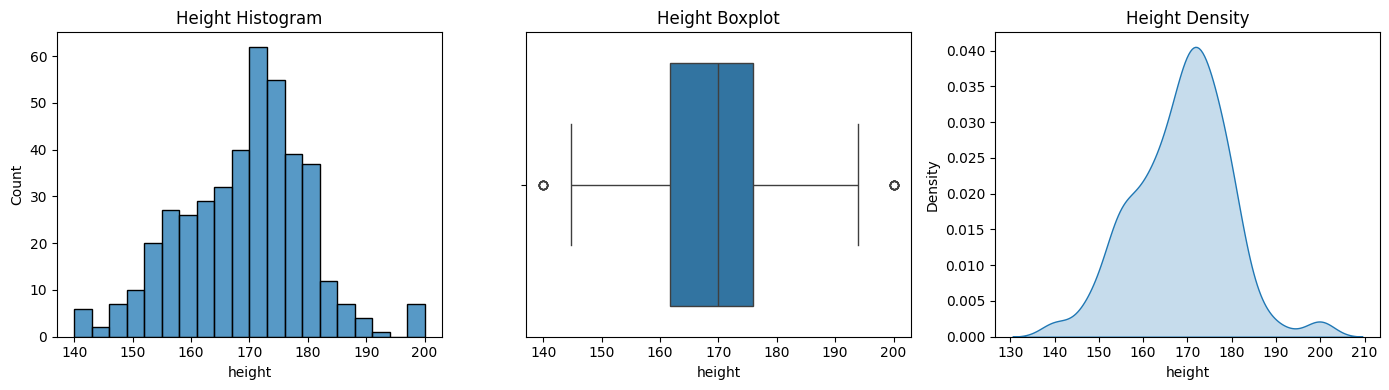

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

# Histogram
plt.subplot(1,3,1)
sns.histplot(train_df['height'], bins=20, kde=False)
plt.title('Height Histogram')

# Boxplot
plt.subplot(1,3,2)
sns.boxplot(x=train_df['height'])
plt.title('Height Boxplot')

# Density plot
plt.subplot(1,3,3)
sns.kdeplot(train_df['height'], fill=True)
plt.title('Height Density')

plt.tight_layout()
plt.show()


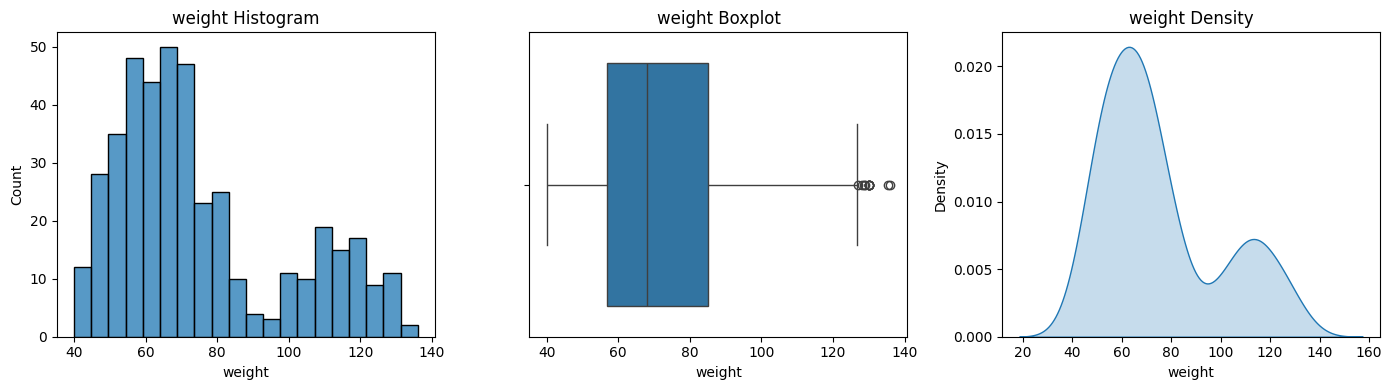

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

# Histogram
plt.subplot(1,3,1)
sns.histplot(train_df['weight'], bins=20, kde=False)
plt.title('weight Histogram')

# Boxplot
plt.subplot(1,3,2)
sns.boxplot(x=train_df['weight'])
plt.title('weight Boxplot')

# Density plot
plt.subplot(1,3,3)
sns.kdeplot(train_df['weight'], fill=True)
plt.title('weight Density')

plt.tight_layout()
plt.show()


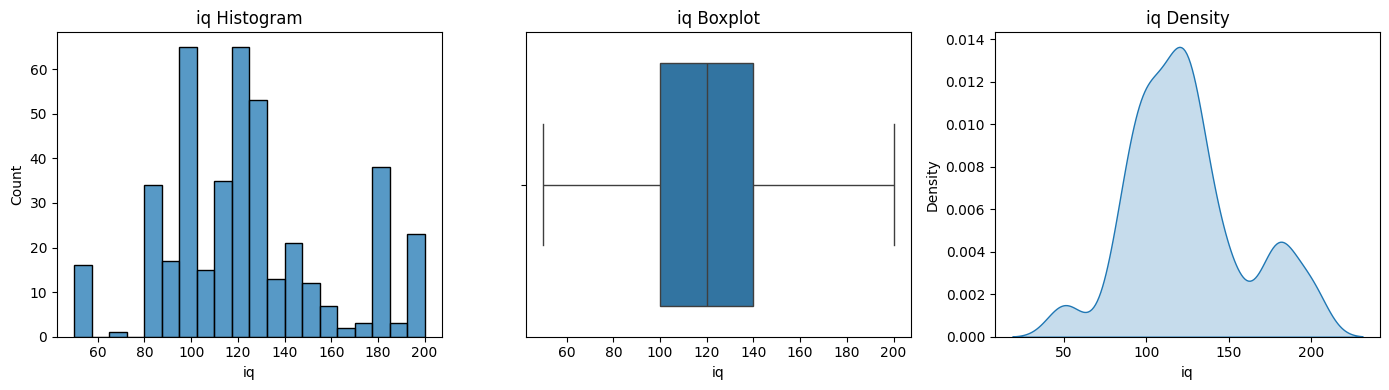

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

# Histogram
plt.subplot(1,3,1)
sns.histplot(train_df['iq'], bins=20, kde=False)
plt.title('iq Histogram')

# Boxplot
plt.subplot(1,3,2)
sns.boxplot(x=train_df['iq'])
plt.title('iq Boxplot')

# Density plot
plt.subplot(1,3,3)
sns.kdeplot(train_df['iq'], fill=True)
plt.title('iq Density')

plt.tight_layout()
plt.show()


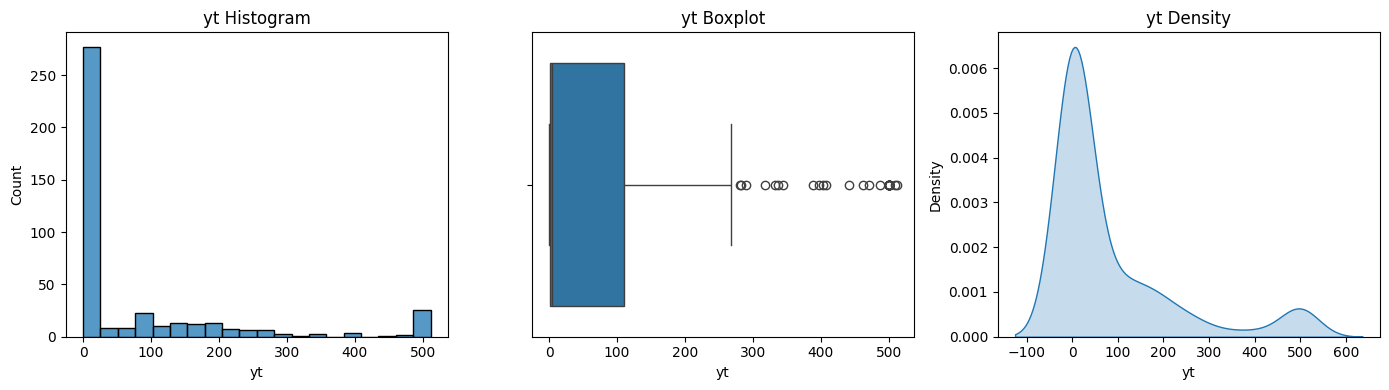

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

# Histogram
plt.subplot(1,3,1)
sns.histplot(train_df['yt'], bins=20, kde=False)
plt.title('yt Histogram')

# Boxplot
plt.subplot(1,3,2)
sns.boxplot(x=train_df['yt'])
plt.title('yt Boxplot')

# Density plot
plt.subplot(1,3,3)
sns.kdeplot(train_df['yt'], fill=True)
plt.title('yt Density')

plt.tight_layout()
plt.show()


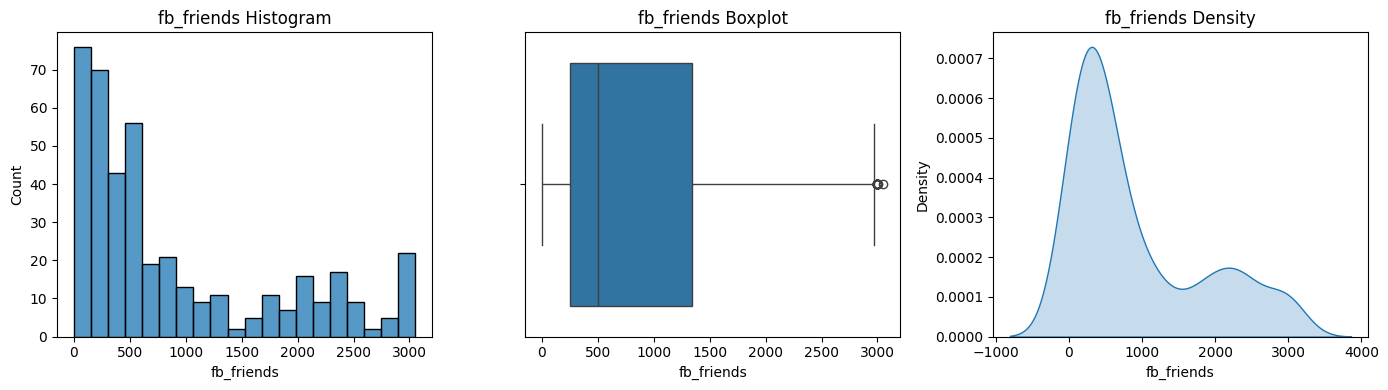

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

# Histogram
plt.subplot(1,3,1)
sns.histplot(train_df['fb_friends'], bins=20, kde=False)
plt.title('fb_friends Histogram')

# Boxplot
plt.subplot(1,3,2)
sns.boxplot(x=train_df['fb_friends'])
plt.title('fb_friends Boxplot')

# Density plot
plt.subplot(1,3,3)
sns.kdeplot(train_df['fb_friends'], fill=True)
plt.title('fb_friends Density')

plt.tight_layout()
plt.show()

height分割區域

In [69]:
# train_df的height 和 weight 同時缺失的筆數
missing_count = train_df[train_df['height'].isnull() & train_df['weight'].isnull()].shape[0]

print(f"身高和體重同時缺失的有 {missing_count} 筆")

身高和體重同時缺失的有 0 筆


In [70]:
# test_df的height 和 weight 同時缺失的筆數
missing_count = test_df[test_df['height'].isnull() & test_df['weight'].isnull()].shape[0]

print(f"身高和體重同時缺失的有 {missing_count} 筆")

身高和體重同時缺失的有 0 筆


height

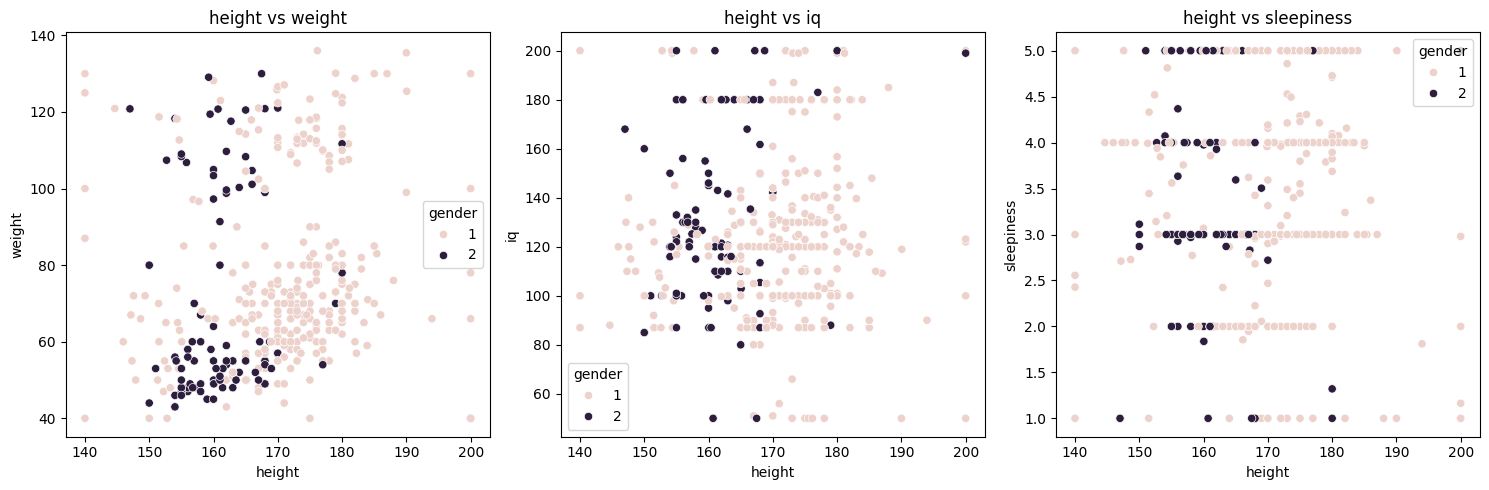

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # (寬, 高)

# 第一張圖
sns.scatterplot(x='height', y='weight', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('height vs weight')

# 第二張圖
sns.scatterplot(x='height', y='iq', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('height vs iq')

# 第三張圖
sns.scatterplot(x='height', y='sleepiness', hue='gender', data=train_df, ax=axes[2])
axes[2].set_title('height vs sleepiness')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'height vs fb_friends')

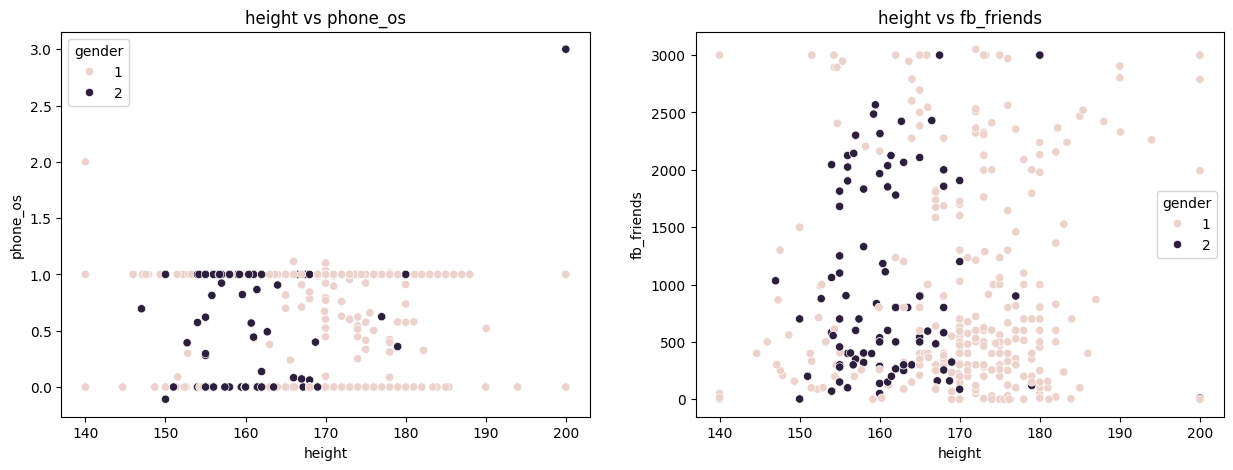

In [72]:
# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='height', y='phone_os', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('height vs phone_os')

# 第二張圖
sns.scatterplot(x='height', y='fb_friends', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('height vs fb_friends')


**補weight**

In [73]:
# # height <= 140
# median_low = train_df.loc[train_df['height'] <= 140, 'weight'].median()
# train_df.loc[(train_df['height'] <= 140) & (train_df['weight'].isnull()), 'weight'] = median_low
# test_df.loc[(test_df['height'] <= 140) & (test_df['weight'].isnull()), 'weight'] = median_low

# # 140 < height <= 160
# median_140_160 = train_df.loc[(train_df['height'] > 140) & (train_df['height'] <= 160), 'weight'].median()
# train_df.loc[(train_df['height'] > 140) & (train_df['height'] <= 160) & (train_df['weight'].isnull()), 'weight'] = median_140_160
# test_df.loc[(test_df['height'] > 140) & (test_df['height'] <= 160) & (test_df['weight'].isnull()), 'weight'] = median_140_160

# # 160 < height < 170 (分男女)
# median_male = train_df.loc[(train_df['height'] > 160) & (train_df['height'] < 170) & (train_df['gender'] == 1), 'weight'].median()
# median_female = train_df.loc[(train_df['height'] > 160) & (train_df['height'] < 170) & (train_df['gender'] == 2), 'weight'].median()

# train_df.loc[(train_df['height'] > 160) & (train_df['height'] < 170) & (train_df['gender'] == 1) & (train_df['weight'].isnull()), 'weight'] = median_male
# train_df.loc[(train_df['height'] > 160) & (train_df['height'] < 170) & (train_df['gender'] == 2) & (train_df['weight'].isnull()), 'weight'] = median_female

# # 170 <= height < 180
# median_170_180 = train_df.loc[(train_df['height'] >= 170) & (train_df['height'] < 180), 'weight'].median()
# train_df.loc[(train_df['height'] >= 170) & (train_df['height'] < 180) & (train_df['weight'].isnull()), 'weight'] = median_170_180
# test_df.loc[(test_df['height'] >= 170) & (test_df['height'] < 180) & (test_df['weight'].isnull()), 'weight'] = median_170_180

# # height >= 180
# median_high = train_df.loc[train_df['height'] >= 180, 'weight'].median()
# train_df.loc[(train_df['height'] >= 180) & (train_df['weight'].isnull()), 'weight'] = median_high
# test_df.loc[(test_df['height'] >= 180) & (test_df['weight'].isnull()), 'weight'] = median_high


**補fb_friends**

In [74]:
# # 先計算該區間的中位數
# median_140_160 = train_df.loc[(train_df['height'] >= 170) & (180 >= train_df['height']), 'fb_friends'].median()

# # 只補 fb_friends 缺失 且 height 在 140 ~ 160 的資料
# train_df.loc[(train_df['height'] >= 170) & (180 >= train_df['height']) & (train_df['fb_friends'].isnull()), 'fb_friends'] = median_140_160
# test_df.loc[(train_df['height'] >= 170) & (180 >= train_df['height']) & (test_df['fb_friends'].isnull()), 'fb_friends'] = median_140_160

weight分割

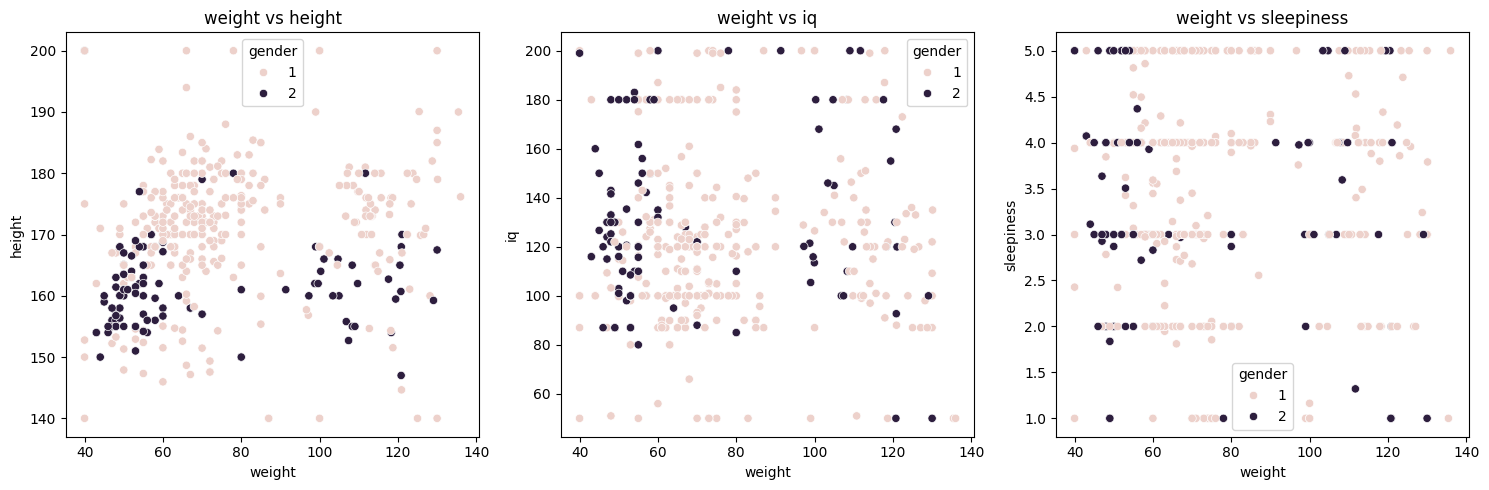

In [75]:
# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='weight', y='height', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('weight vs height')

# 第二張圖
sns.scatterplot(x='weight', y='iq', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('weight vs iq')

# 第三張圖
sns.scatterplot(x='weight', y='sleepiness', hue='gender', data=train_df, ax=axes[2])
axes[2].set_title('weight vs sleepiness')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'weight vs fb_friends')

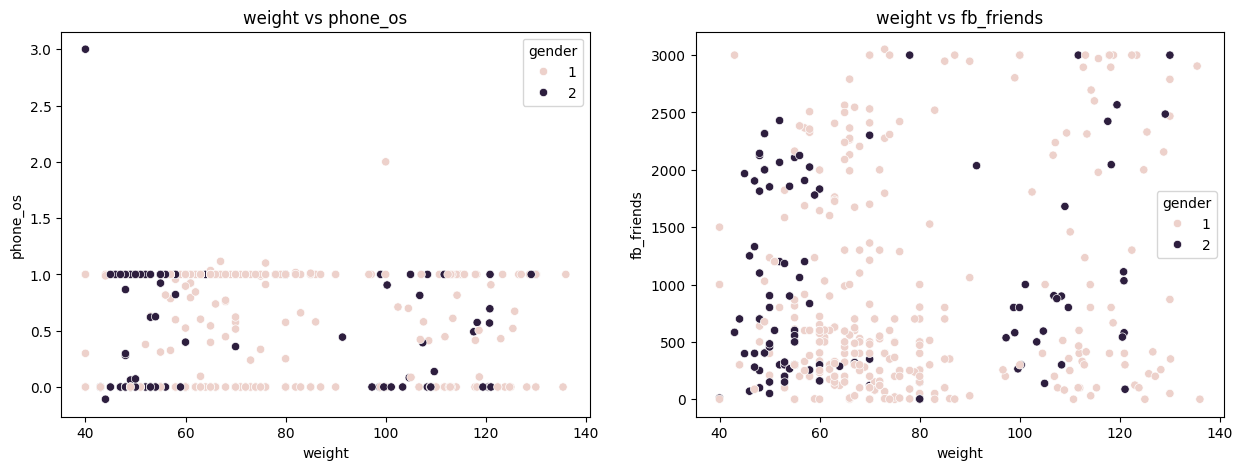

In [76]:
# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='weight', y='phone_os', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('weight vs phone_os')

# 第二張圖
sns.scatterplot(x='weight', y='fb_friends', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('weight vs fb_friends')


**補height**

In [77]:
# # 計算 40 >= weight 的 height 中位數
# median_low = train_df.loc[40 >= train_df['weight'], 'height'].median()

# # 只補 weight =< 40 & height 缺失 的資料
# train_df.loc[(40 >= train_df['weight']) & (train_df['height'].isnull()), 'height'] = median_low
# test_df.loc[(40 >= train_df['weight']) & (test_df['height'].isnull()), 'height'] = median_low

# # 計算 weight>80 的 height 中位數
# median_low = train_df.loc[train_df['weight'] > 80, 'height'].median()

# # 只補 weight >80 & height 缺失 的資料
# train_df.loc[(train_df['weight'] > 80) & (train_df['height'].isnull()), 'height'] = median_low
# test_df.loc[(train_df['weight'] > 80) & (test_df['height'].isnull()), 'height'] = median_low

In [78]:
# # 計算60~80區間height的中位數
# # 男生
# median_male = train_df.loc[(80 >= train_df['weight']) & (train_df['weight'] >= 60) & (train_df['gender'] == 1), 'height'].median()

# # 女生
# median_female = train_df.loc[(80 >= train_df['weight']) & (train_df['weight'] >= 60) & (train_df['gender'] == 2), 'height'].median()

# # 男生補值
# train_df.loc[(80 >= train_df['weight']) & (train_df['weight'] >= 60) & (train_df['gender'] == 1) & (train_df['height'].isnull()), 'height'] = median_male

# # 女生補值
# train_df.loc[(80 >= train_df['weight']) & (train_df['weight'] >= 60) & (train_df['gender'] == 2) & (train_df['height'].isnull()), 'height'] = median_female

In [79]:
# # 計算40~60區間height的中位數
# # 男生
# median_male = train_df.loc[(60 > train_df['weight']) & (train_df['weight'] > 40) & (train_df['gender'] == 1), 'height'].median()

# # 女生
# median_female = train_df.loc[(60 > train_df['weight']) & (train_df['weight'] > 40) & (train_df['gender'] == 2), 'height'].median()

# # 男生補值
# train_df.loc[(60 > train_df['weight']) & (train_df['weight'] > 40) & (train_df['gender'] == 1) & (train_df['height'].isnull()), 'height'] = median_male

# # 女生補值
# train_df.loc[(60 > train_df['weight']) & (train_df['weight'] > 40) & (train_df['gender'] == 2) & (train_df['height'].isnull()), 'height'] = median_female

**補fb_friends**

In [80]:
# # 計算60~70區間fb_friends的中位數
# median_60_70 = train_df.loc[(train_df['weight'] >= 60) & (70 > train_df['weight']), 'fb_friends'].median()

# train_df.loc[(train_df['weight'] >= 60) & (70 > train_df['weight']) & (train_df['fb_friends'].isnull()), 'fb_friends'] = median_60_70
# test_df.loc[(train_df['weight'] >= 60) & (70 > train_df['weight']) & (test_df['fb_friends'].isnull()), 'fb_friends'] = median_60_70
# # 計算70~80區間fb_friends的中位數
# median_70_80 = train_df.loc[(train_df['weight'] >= 60) & (70 >= train_df['weight']), 'fb_friends'].median()

# train_df.loc[(train_df['weight'] >= 70) & (80 >= train_df['weight']) & (train_df['fb_friends'].isnull()), 'fb_friends'] = median_70_80
# test_df.loc[(train_df['weight'] >= 70) & (80 >= train_df['weight']) & (test_df['fb_friends'].isnull()), 'fb_friends'] = median_70_80

fb_friends

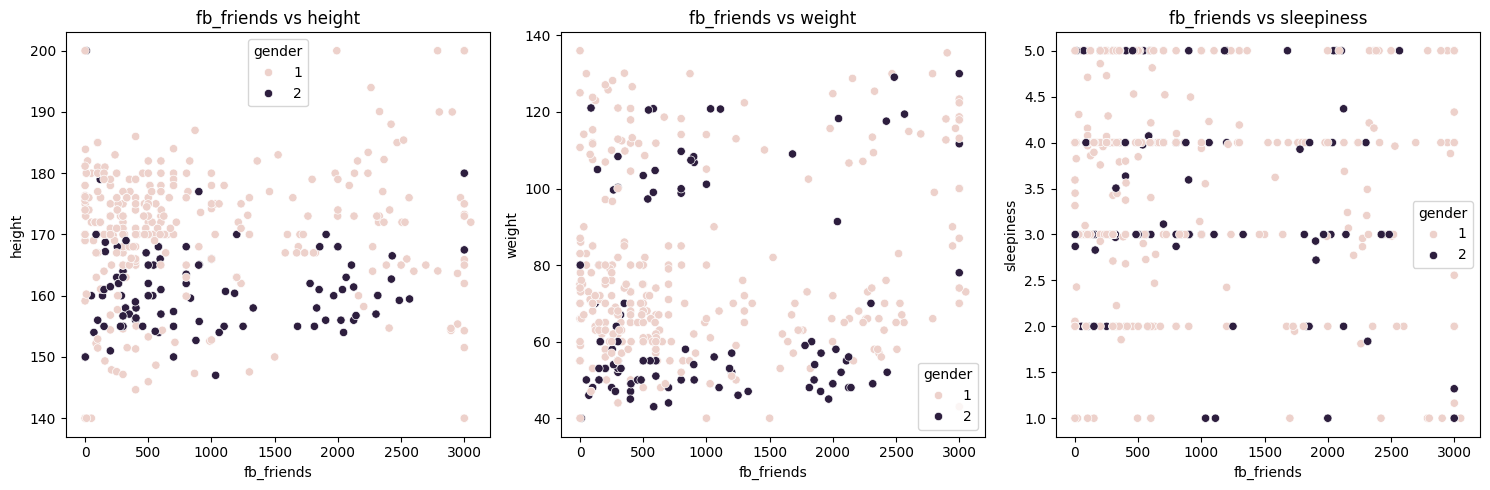

In [81]:
# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='fb_friends', y='height', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('fb_friends vs height')

# 第二張圖
sns.scatterplot(x='fb_friends', y='weight', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('fb_friends vs weight')

# 第三張圖
sns.scatterplot(x='fb_friends', y='sleepiness', hue='gender', data=train_df, ax=axes[2])
axes[2].set_title('fb_friends vs sleepiness')

plt.tight_layout()
plt.show()

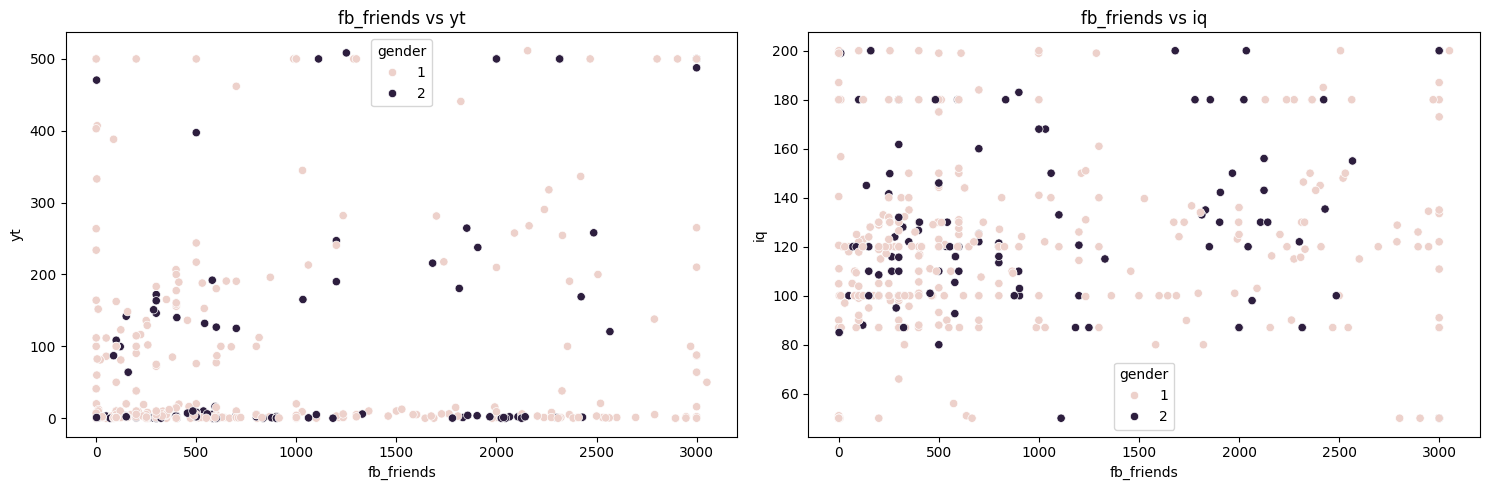

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# 建立 1 行 2 列的 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='fb_friends', y='yt', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('fb_friends vs yt')

# 第二張圖
sns.scatterplot(x='fb_friends', y='iq', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('fb_friends vs iq')

plt.tight_layout()
plt.show()

In [83]:
# # fb_friends 用median補值
# median_fb = train_df['fb_friends'].median()
# train_df.loc[train_df['fb_friends'].isnull(), 'fb_friends'] = median_fb
# test_df.loc[test_df['fb_friends'].isnull(), 'fb_friends'] = median_fb

yt

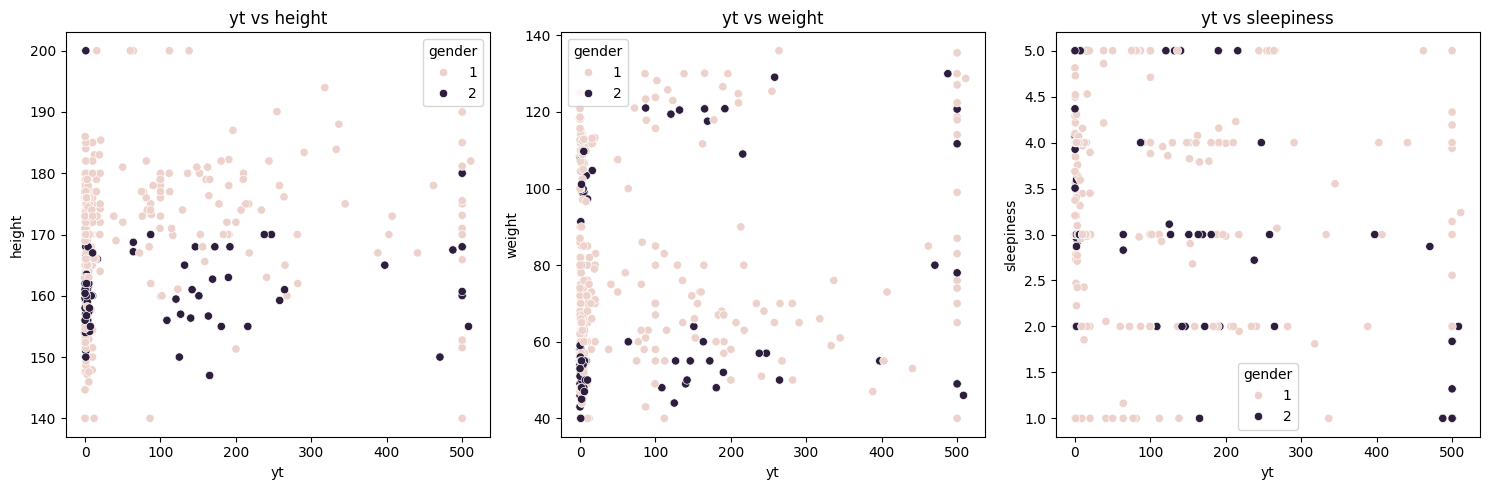

In [84]:
# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='yt', y='height', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('yt vs height')

# 第二張圖
sns.scatterplot(x='yt', y='weight', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('yt vs weight')

# 第三張圖
sns.scatterplot(x='yt', y='sleepiness', hue='gender', data=train_df, ax=axes[2])
axes[2].set_title('yt vs sleepiness')

plt.tight_layout()
plt.show()

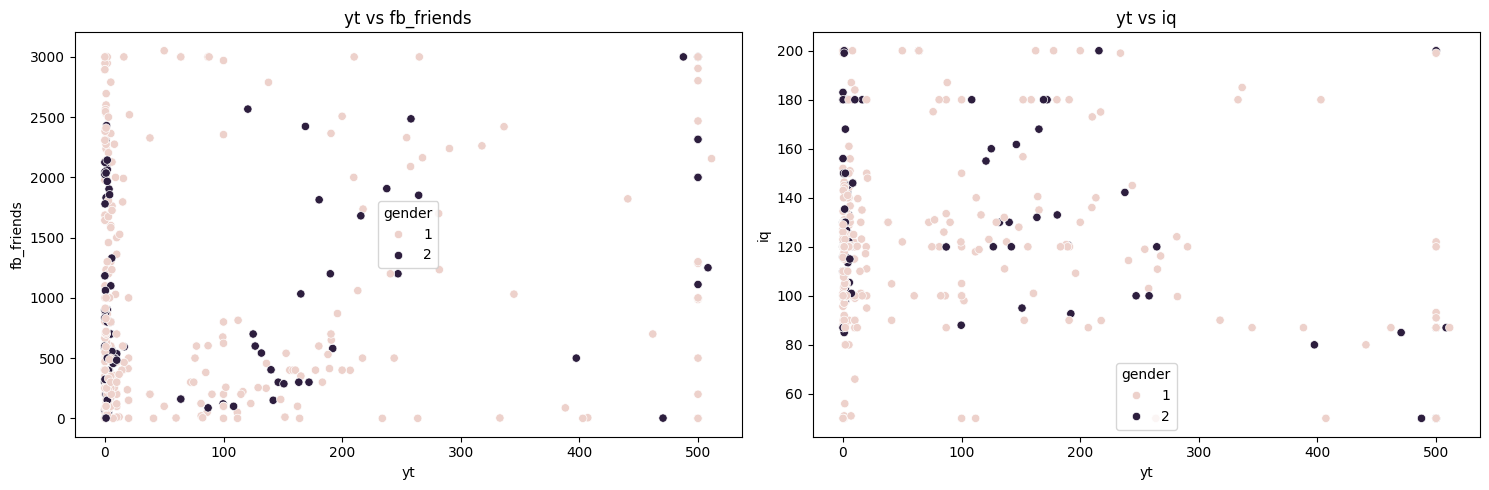

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# 建立 1 行 2 列的 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='yt', y='fb_friends', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('yt vs fb_friends')

# 第二張圖
sns.scatterplot(x='yt', y='iq', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('yt vs iq')

plt.tight_layout()
plt.show()

In [86]:
# # yt median 補值
# median_yt = train_df['yt'].median()
# train_df.loc[train_df['yt'].isnull(), 'yt'] = median_yt
# test_df.loc[test_df['yt'].isnull(), 'yt'] = median_yt

iq

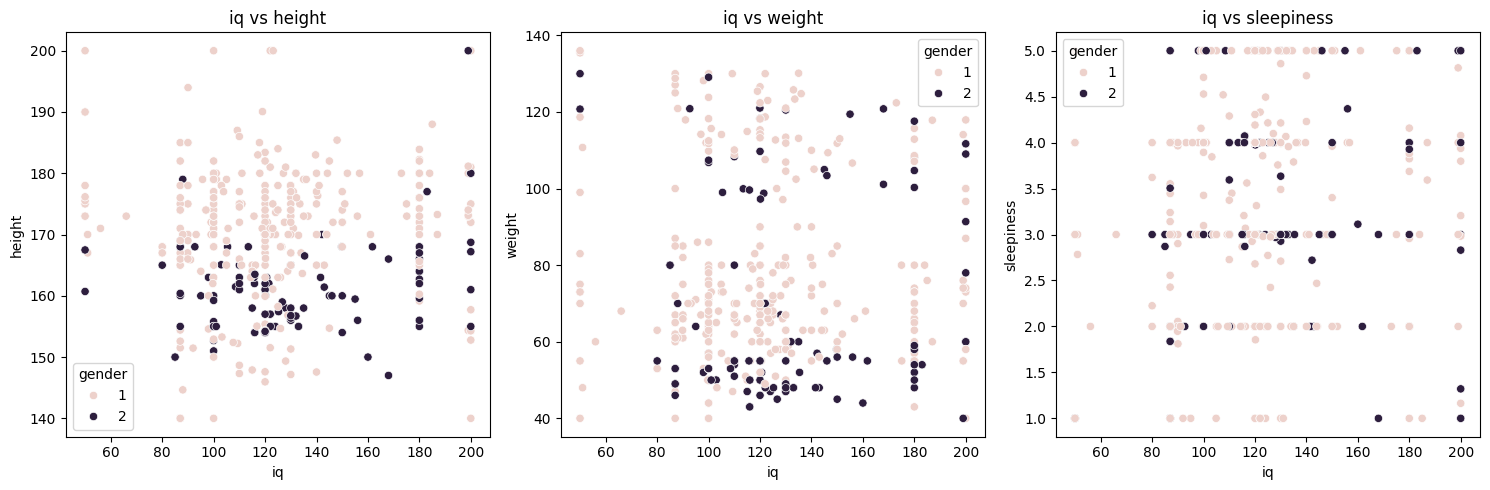

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# 建立 1 行 3 列的 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # (寬, 高)

# 第一張圖
sns.scatterplot(x='iq', y='height', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('iq vs height')

# 第二張圖
sns.scatterplot(x='iq', y='weight', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('iq vs weight')

# 第三張圖
sns.scatterplot(x='iq', y='sleepiness', hue='gender', data=train_df, ax=axes[2])
axes[2].set_title('iq vs sleepiness')

plt.tight_layout()
plt.show()


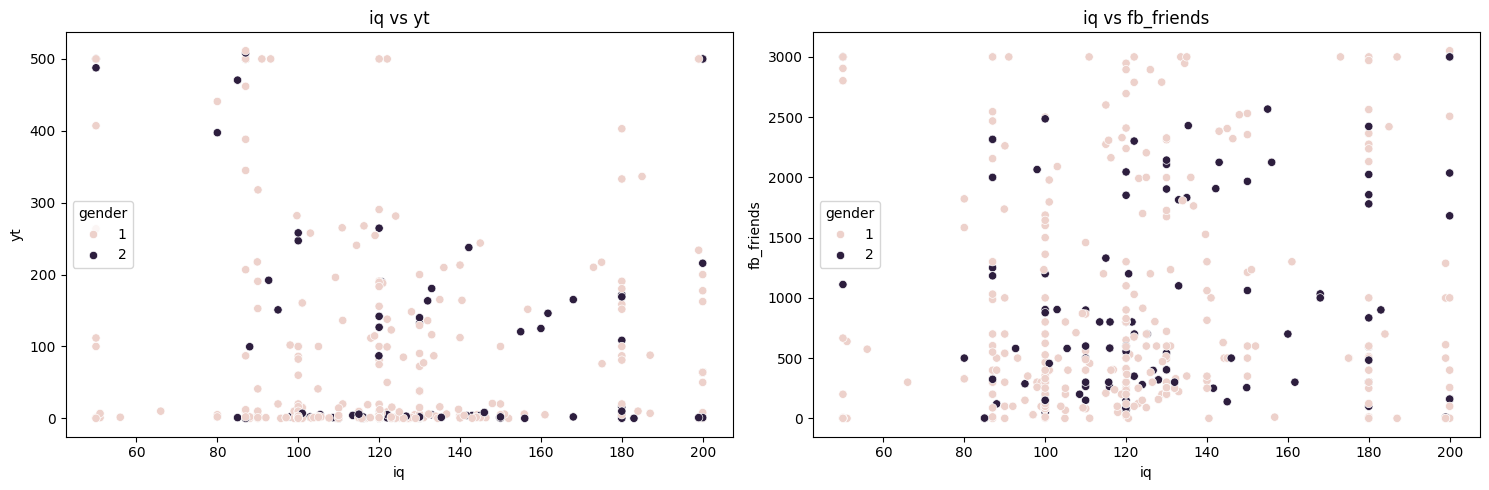

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# 建立 1 行 2 列的 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 第一張圖
sns.scatterplot(x='iq', y='yt', hue='gender', data=train_df, ax=axes[0])
axes[0].set_title('iq vs yt')

# 第二張圖
sns.scatterplot(x='iq', y='fb_friends', hue='gender', data=train_df, ax=axes[1])
axes[1].set_title('iq vs fb_friends')

plt.tight_layout()
plt.show()

In [89]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import KNNImputer
# from sklearn.neighbors import KNeighborsRegressor
# import seaborn as sns
# import matplotlib.pyplot as plt

# predictor_cols = ['height', 'weight', 'gender', 'fb_friends', 'yt', 'sleepiness']
# target_col = 'iq'

# train_df_copy = train_df.copy()
# test_df_copy = test_df.copy()

# # 補 predictor 缺失
# scaler = StandardScaler()
# train_df_copy[predictor_cols] = scaler.fit_transform(train_df_copy[predictor_cols])
# test_df_copy[predictor_cols] = scaler.transform(test_df_copy[predictor_cols])

# imputer = KNNImputer(n_neighbors=5)
# train_df_copy[predictor_cols] = imputer.fit_transform(train_df_copy[predictor_cols])
# test_df_copy[predictor_cols] = imputer.transform(test_df_copy[predictor_cols])

# # KNN Regression補iq
# model = KNeighborsRegressor(n_neighbors=5)
# model.fit(train_df_copy[train_df[target_col].notnull()][predictor_cols],
#           train_df[train_df[target_col].notnull()][target_col])

# train_df.loc[train_df[target_col].isnull(), target_col] = model.predict(train_df_copy.loc[train_df[target_col].isnull(), predictor_cols])
# test_df.loc[test_df[target_col].isnull(), target_col] = model.predict(test_df_copy.loc[test_df[target_col].isnull(), predictor_cols])

# # 分佈圖
# plt.figure(figsize=(10,5))
# sns.kdeplot(train_df[target_col], label='補值後', fill=True)
# sns.kdeplot(train_df[train_df[target_col].notnull()][target_col], label='原始非缺失', linestyle='--')
# plt.title('IQ 補值前後分佈')
# plt.legend()
# plt.show()

In [90]:
# #類別欄位補值
# for target, predictors in cat_predictor_dict.items():
#     print(f'正在處理: {target}')

#     train_df, test_df = dt_impute_classifier(
#         train_df=train_df,
#         test_df=test_df,
#         target_col=target,
#         predictor_cols=predictors
#     )

#     print(f'{target} 缺失值統計 (train):')
#     print(train_df[[target]].isnull().sum())
#     print(f'{target} 缺失值統計 (test):')
#     print(test_df[[target]].isnull().sum())

In [91]:
# #XGBoost
# import xgboost as xgb

# def train_xgb_imputer(train_df):
#     imputer_models = {}
#     for col in train_df.columns:
#         known = train_df[train_df[col].notnull()]
#         if len(known) > 0:
#             model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
#             model.fit(known.drop(columns=[col]), known[col])
#             imputer_models[col] = model
#     return imputer_models

# def impute_with_xgb(train_df, test_df, imputer_models):
#     df_test_imputed = test_df.copy()
#     for col, model in imputer_models.items():
#         unknown = df_test_imputed[df_test_imputed[col].isnull()]
#         if len(unknown) > 0:
#             predictions = model.predict(unknown.drop(columns=[col]))

#             # 根據原始資料型態來決定轉換方式
#             if pd.api.types.is_integer_dtype(train_df[col]):
#                 predictions = pd.Series(predictions).round().astype(pd.Int64Dtype()).to_numpy()

#             df_test_imputed.loc[df_test_imputed[col].isnull(), col] = predictions

#     return df_test_imputed



# xgb_models = train_xgb_imputer(train_df)
# models = train_xgb_imputer(train_df)

# train_df = impute_with_xgb(train_df, train_df, models)
# test_df = impute_with_xgb(train_df, test_df, models)

## 3.4 查看分布

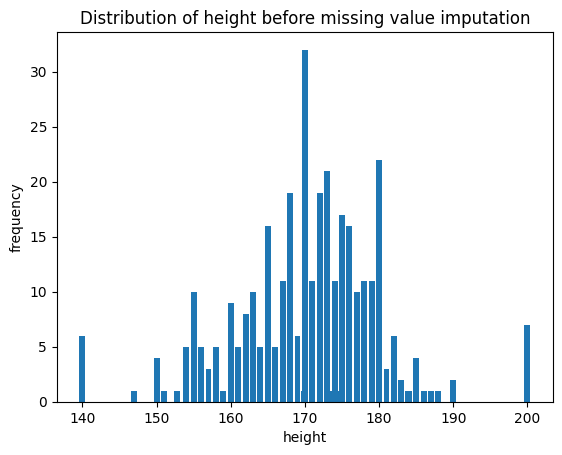

In [92]:
height_values = train_df_before['height'].unique()

# 計算每個height的出現次數
value_counts = train_df_before['height'].value_counts()

# 重新索引value_counts，確保所有unique_values都包含在內，缺少的值填入 0
value_counts = value_counts.reindex(height_values, fill_value = 0)

# 使用 Matplotlib 繪製長條圖
plt.bar(height_values, value_counts)
plt.xlabel('height')
plt.ylabel('frequency')
plt.title('Distribution of height before missing value imputation')
plt.show()

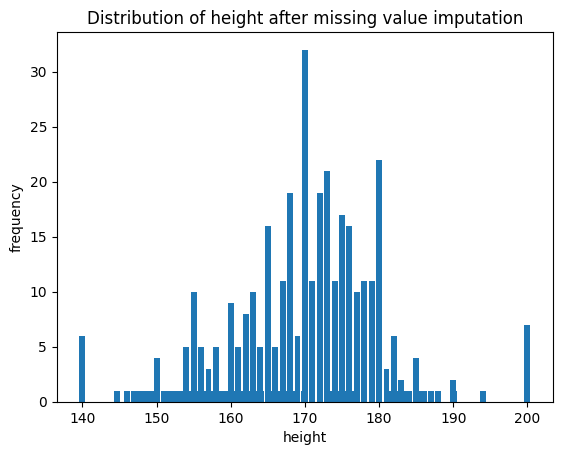

In [93]:
height_values = train_df['height'].unique()
value_counts = train_df['height'].value_counts()
value_counts = value_counts.reindex(height_values, fill_value = 0)

plt.bar(height_values, value_counts)
plt.xlabel('height')
plt.ylabel('frequency')
plt.title('Distribution of height after missing value imputation')
plt.show()

<Axes: >

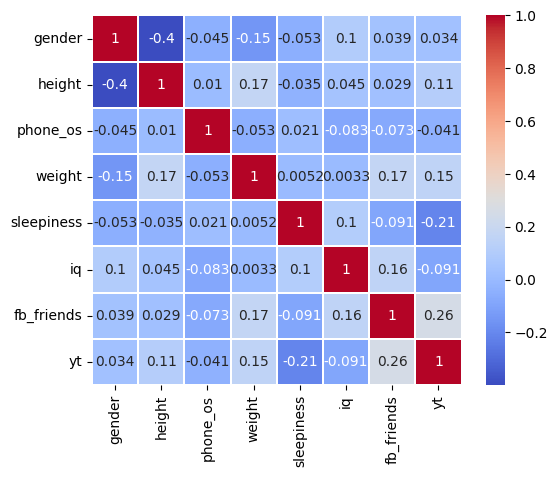

In [94]:
# 數值欄位相關性
#負擔（負擔相關）：表示兩個變數的逆轉變化（例如性別增加，身高減少）。
#正數（正相關）：表示兩個變化數同向變化（例如身高增加，體重增加）。
sns.heatmap(train_df[['gender', 'height', 'phone_os', 'weight', 'sleepiness', 'iq', 'fb_friends', 'yt']].corr(),linewidths=0.1,vmax=1.0,cmap="coolwarm" , square=True,linecolor='white', annot=True)

<Axes: >

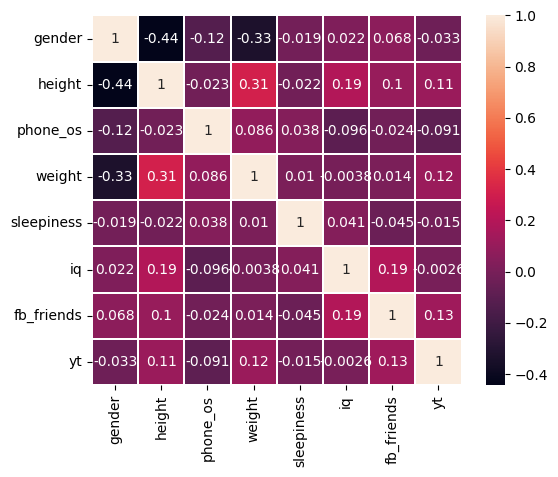

In [95]:
sns.heatmap(test_df[['gender', 'height', 'phone_os', 'weight', 'sleepiness', 'iq', 'fb_friends', 'yt']].corr(),linewidths=0.1,vmax=1.0, square=True,linecolor='white', annot=True)

In [96]:
train_df.isnull().sum()

,0
gender,0
phone_os,0
height,0
weight,0
sleepiness,0
iq,0
fb_friends,0
yt,0
is_outlier_fb_friends,0
is_outlier_yt,0


In [97]:
test_df.isnull().sum()

,0
gender,0
phone_os,0
height,0
weight,0
sleepiness,0
iq,0
fb_friends,0
yt,0
is_outlier_fb_friends,0
is_outlier_yt,0


# **4. 編碼文字欄位(self_intro)**


In [98]:
test_df['gender'] = np.nan

<h2>4.1 文字前處理

In [99]:
train_df['self_intro'] = self_train_backup.loc[train_df.index]
test_df['self_intro'] = self_test_backup.loc[test_df.index]

In [100]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# 下載 NLTK 資源（確保包含 punkt_tab）
nltk.download('punkt')        # 基本分詞資源
nltk.download('punkt_tab')    # 新版 NLTK 需要的分詞資源
nltk.download('stopwords')    # 停用詞

# 定義前處理函數
def preprocess_text(text):
    # 轉小寫
    text = text.lower()
    # 分詞
    tokens = word_tokenize(text)
    # 移除停用詞和標點
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # 詞幹提取
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # 合併回字符串
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [101]:
train_df['self_intro'] = train_df['self_intro'].fillna('').apply(preprocess_text)
test_df['self_intro'] = test_df['self_intro'].fillna('').apply(preprocess_text)

<h2> 4.2 TF-IDF

In [102]:
train_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt,is_outlier_fb_friends,is_outlier_yt,is_outlier_height,is_outlier_weight,is_outlier_iq,self_intro
0,2,0.000000,154.0,43.0,4.071842,115.969353,583.000000,0.00000,0,0,0,0,1,beauti
1,2,0.000000,156.0,47.0,2.928009,130.000000,1903.295898,3.50000,1,0,0,0,0,enjoy notsss
2,1,0.793504,170.0,61.0,2.901227,90.000000,540.000000,152.76976,0,1,0,0,0,practic make perfect
3,1,0.000000,170.0,62.0,4.000000,100.000000,1600.708740,5.00000,1,0,0,0,0,straightforward
4,2,1.000000,158.0,67.0,2.968550,128.000000,320.000000,1.20000,0,0,0,0,0,humor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1,1.000000,166.0,66.0,4.000000,90.000000,1000.000000,1.00000,0,0,0,0,0,hope super hero
419,1,1.000000,176.0,65.0,4.000000,87.000000,1300.000000,2.00000,0,0,0,0,0,
420,1,0.000000,174.0,72.0,2.000000,124.990738,2000.000000,9.00000,1,0,0,0,1,
421,2,0.071891,167.0,50.0,3.000000,180.000000,483.000000,10.00000,0,0,0,0,0,


In [103]:
test_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt,is_outlier_fb_friends,is_outlier_yt,is_outlier_height,is_outlier_weight,is_outlier_iq,self_intro
0,NaN,0.000000,200.0,100.000000,1.000000,87.000000,87.000000,87.000000,0,1,1,1,0,good
1,NaN,0.000000,175.0,80.000000,3.000000,140.788818,2000.000000,246.914169,1,1,0,0,1,easygo
2,NaN,0.000000,155.0,45.000000,3.000000,150.000000,2038.108887,9.000000,1,0,0,0,0,
3,NaN,0.000000,173.0,85.000000,4.000000,137.401123,2281.253174,15.000000,1,0,0,0,1,
4,NaN,1.000000,164.0,57.000000,4.000000,130.000000,505.000000,2.000000,0,0,0,0,0,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,0.000000,160.0,70.000000,4.000000,125.273056,500.000000,5.000000,0,0,0,0,1,girl
422,NaN,1.000000,162.0,54.000000,3.000000,180.000000,462.000000,5.000000,0,0,0,0,0,
423,NaN,0.000000,173.0,66.000000,3.342718,135.000000,102.000000,11.100000,0,0,0,0,0,like play basketbal
424,NaN,0.357246,165.0,53.000000,3.912219,110.000000,507.000000,416.000000,0,1,0,0,0,good


In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. 補空字串
train_df['self_intro'] = train_df['self_intro'].fillna("")

# 2. 向量轉換
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(train_df['self_intro'])

# 3. 建立 DataFrame 並保留原 index
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=train_df.index
)

# 4. 合併
train_df = pd.concat([train_df.drop(columns=['self_intro']), tfidf_df], axis=1)
vectorizer.get_feature_names_out()

array(['123', 'alway', 'amaz', 'awesom', 'beauti', 'big', 'bore', 'boy',
       'brilliant', 'care', 'chika', 'color', 'common', 'cool', 'could',
       'curiou', 'cute', 'daili', 'damon', 'defin', 'despair', 'die',
       'dope', 'dream', 'eight', 'ellen', 'enjoy', 'etern', 'fake', 'fat',
       'fintech', 'fish', 'foodi', 'foolish', 'four', 'free', 'gentl',
       'girl', 'go', 'goat', 'god', 'good', 'gorgeou', 'got', 'guy',
       'haha', 'handsom', 'happi', 'hard', 'hello', 'hi', 'hopeless',
       'human', 'humor', 'hungri', 'intellig', 'kind', 'know', 'lazi',
       'less', 'like', 'love', 'man', 'mikoto', 'misaka', 'morn', 'na',
       'nerd', 'never', 'nice', 'nihilisim', 'normal', 'old', 'orang',
       'other', 'peopl', 'person', 'play', 'posit', 'quit', 'run', 'show',
       'simpl', 'six', 'sleep', 'smart', 'smile', 'stay',
       'straightforward', 'student', 'super', 'takami', 'tire', 'wan',
       'want', 'wise', 'work', 'world', 'xd', 'zzzz'], dtype=object)

In [105]:
train_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt,is_outlier_fb_friends,is_outlier_yt,...,super,takami,tire,wan,want,wise,work,world,xd,zzzz
0,2,0.000000,154.0,43.0,4.071842,115.969353,583.000000,0.00000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.000000,156.0,47.0,2.928009,130.000000,1903.295898,3.50000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.793504,170.0,61.0,2.901227,90.000000,540.000000,152.76976,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.000000,170.0,62.0,4.000000,100.000000,1600.708740,5.00000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1.000000,158.0,67.0,2.968550,128.000000,320.000000,1.20000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1,1.000000,166.0,66.0,4.000000,90.000000,1000.000000,1.00000,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419,1,1.000000,176.0,65.0,4.000000,87.000000,1300.000000,2.00000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420,1,0.000000,174.0,72.0,2.000000,124.990738,2000.000000,9.00000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421,2,0.071891,167.0,50.0,3.000000,180.000000,483.000000,10.00000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# 1. 填補空值（防止 NaN 導致 TF-IDF 出錯）
test_df['self_intro'] = test_df['self_intro'].fillna("")

# 2. 套用已訓練好的 vectorizer（⚠️ 不能再用 fit_transform）
X_test_tfidf = vectorizer.transform(test_df['self_intro'])

# 3. 轉成 DataFrame（⚠️ index 要對齊）
tfidf_test_df = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=test_df.index
)

# 4. 合併進 test_df（移除原本的 self_intro）
test_df = pd.concat([test_df.drop(columns=['self_intro']), tfidf_test_df], axis=1)



In [107]:
test_df

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt,is_outlier_fb_friends,is_outlier_yt,...,super,takami,tire,wan,want,wise,work,world,xd,zzzz
0,NaN,0.000000,200.0,100.000000,1.000000,87.000000,87.000000,87.000000,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,0.000000,175.0,80.000000,3.000000,140.788818,2000.000000,246.914169,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.000000,155.0,45.000000,3.000000,150.000000,2038.108887,9.000000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.000000,173.0,85.000000,4.000000,137.401123,2281.253174,15.000000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,1.000000,164.0,57.000000,4.000000,130.000000,505.000000,2.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,0.000000,160.0,70.000000,4.000000,125.273056,500.000000,5.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422,NaN,1.000000,162.0,54.000000,3.000000,180.000000,462.000000,5.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,NaN,0.000000,173.0,66.000000,3.342718,135.000000,102.000000,11.100000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,NaN,0.357246,165.0,53.000000,3.912219,110.000000,507.000000,416.000000,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#  **5. 特徵選取**

In [108]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

selected_cols = ['gender', 'phone_os', 'height', 'weight', 'sleepiness', 'iq', 'fb_friends', 'yt']
train_df_fs = train_df[selected_cols]
test_df_fs = test_df[selected_cols]

print(f"資料集筆數: {train_df_fs.shape[0]}, 特徵數量: {train_df_fs.shape[1]-1}")

資料集筆數: 423, 特徵數量: 7


## 5.1 特徵選擇

### 5.1.1 Embedded  method 嵌入式

#### 使用 RF 評估特徵

In [109]:
train_df_fs = clean_data(train_df_fs)

X = train_df_fs.drop('gender', axis=1)
y = train_df_fs['gender']

# 切分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"訓練資料筆數: {X_train.shape[0]}, 測試資料筆數: {X_test.shape[0]}")

訓練資料筆數: 317, 測試資料筆數: 106


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def evaluate_top_n_features(X_train, X_test, y_train, y_test, max_features=5):
    results = []

    # 訓練 baseline 模型並計算全特徵的重要性
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    importances = rf_model.feature_importances_
    feature_names = X_train.columns.tolist()
    feat_imp_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

    print("所有特徵的重要性排序：")
    for name, imp in feat_imp_pairs:
        print(f"{name}: {imp:.4f}")

    # 針對最重要特徵分別訓練模型
    for n in range(1, max_features + 1):
        selected_features = [f for f, imp in feat_imp_pairs[:n]]
        X_train_sel = X_train[selected_features]
        X_test_sel = X_test[selected_features]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "num_features": n,
            "features": selected_features,
            "accuracy": acc
        })

    return results

In [111]:
results = evaluate_top_n_features(X_train, X_test, y_train, y_test, max_features=5)
print("\n各特徵數的準確率比較：")
for r in results:
    print(f"{r['num_features']} 個特徵 → Accuracy: {r['accuracy']:.3f}, 特徵: {r['features']}")

所有特徵的重要性排序：
height: 0.3442
weight: 0.2017
yt: 0.1112
fb_friends: 0.1104
iq: 0.1048
sleepiness: 0.0834
phone_os: 0.0444

各特徵數的準確率比較：
1 個特徵 → Accuracy: 0.840, 特徵: ['height']
2 個特徵 → Accuracy: 0.802, 特徵: ['height', 'weight']
3 個特徵 → Accuracy: 0.811, 特徵: ['height', 'weight', 'yt']
4 個特徵 → Accuracy: 0.821, 特徵: ['height', 'weight', 'yt', 'fb_friends']
5 個特徵 → Accuracy: 0.868, 特徵: ['height', 'weight', 'yt', 'fb_friends', 'iq']


#### XGBoost 進行特徵重要性分析

In [112]:
pip install xgboost shap matplotlib pandas scikit-learn

In [113]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

X = train_df_fs.drop('gender', axis=1).astype('float64')
y = train_df_fs['gender'].replace({1: 0, 2: 1})

X_encoded = X.copy()
for col in ['phone_os', 'sleepiness']:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 36039 (\N{CJK UNIFIED IDEOGRAPH-8CC7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 35338 (\N{CJK UNIFIED IDEOGRAPH-8A0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 22686 (\N{CJK UNIFIED IDEOGRAPH-589E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-3d4535be4cd7>:12: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) miss

<Figure size 800x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas

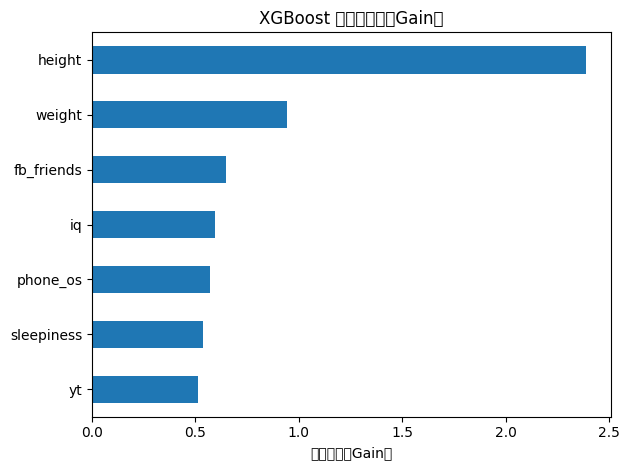

In [114]:
booster = model.get_booster()
importance_gain = booster.get_score(importance_type='gain')

# 轉成 DataFrame
importance_df = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['Gain'])
importance_df = importance_df.sort_values(by='Gain', ascending=True)

plt.figure(figsize=(8, 6))
importance_df.plot(kind='barh', legend=False)
plt.title('XGBoost 特徵重要性（Gain）')
plt.xlabel('資訊增益（Gain）')
plt.tight_layout()
plt.show()

### 5.1.2 Wrapper method 包裝式

#### 使用 RFE 進行特徵選取

In [115]:
pip install pandas scikit-learn matplotlib

In [116]:
train_df_fs

,gender,phone_os,height,weight,sleepiness,iq,fb_friends,yt
0,2,0.000000,154.0,43.0,4.071842,115.969353,583.000000,0.00000
1,2,0.000000,156.0,47.0,2.928009,130.000000,1903.295898,3.50000
2,1,0.793504,170.0,61.0,2.901227,90.000000,540.000000,152.76976
3,1,0.000000,170.0,62.0,4.000000,100.000000,1600.708740,5.00000
4,2,1.000000,158.0,67.0,2.968550,128.000000,320.000000,1.20000
...,...,...,...,...,...,...,...,...
418,1,1.000000,166.0,66.0,4.000000,90.000000,1000.000000,1.00000
419,1,1.000000,176.0,65.0,4.000000,87.000000,1300.000000,2.00000
420,1,0.000000,174.0,72.0,2.000000,124.990738,2000.000000,9.00000
421,2,0.071891,167.0,50.0,3.000000,180.000000,483.000000,10.00000


In [117]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

X = train_df_fs.drop('gender', axis=1)
y = train_df_fs['gender']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 設定選取 5 個特徵
rfe = RFE(estimator=model, n_features_to_select=5)

# 套用 RFE
X_rfe = rfe.fit_transform(X_scaled, y)

# 顯示被選中的特徵
selected_features = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
})

print(selected_features.sort_values(by='Ranking'))

      Feature  Selected  Ranking
1      height      True        1
2      weight      True        1
5  fb_friends      True        1
4          iq      True        1
6          yt      True        1
3  sleepiness     False        2
0    phone_os     False        3


In [119]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_rfe, y, cv=10, scoring='accuracy')
print(f'平均準確率：{scores.mean():.4f}')
print(f'標準差：{scores.std():.4f}')

平均準確率：0.8584
標準差：0.0542


### 5.1.3 Filter method

#### 卡方檢定

In [120]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [121]:
X = train_df_fs.drop(columns=['gender'])
y = train_df_fs['gender'].map({1: 0, 2: 1})

# 卡方檢定需要非負因此將特徵標準化
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 計算卡方統計量與 p 值
chi2_scores, p_values = chi2(X_scaled, y)
chi2_result = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'p_value': p_values
})

# 根據分數排序
chi2_result = chi2_result.sort_values(by='Chi2_Score', ascending=False)
print(chi2_result)

      Feature  Chi2_Score   p_value
1      height    4.434838  0.035213
2      weight    1.675707  0.195496
4          iq    0.477802  0.489420
6          yt    0.229801  0.631671
5  fb_friends    0.186915  0.665497
3  sleepiness    0.158396  0.690638
0    phone_os    0.096390  0.756206


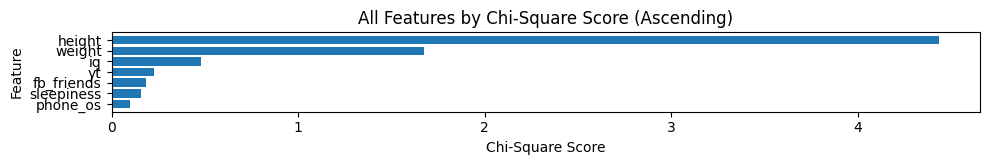

In [122]:
# 依照 Chi2 分數由小排到大
chi2_result_sorted = chi2_result.sort_values(by='Chi2_Score', ascending=True)

# 畫出所有特徵
plt.figure(figsize=(10, len(chi2_result_sorted) * 0.25))  # 動態調整高度
plt.barh(chi2_result_sorted['Feature'], chi2_result_sorted['Chi2_Score'])
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.title('All Features by Chi-Square Score (Ascending)')
plt.tight_layout()
plt.show()

#### ANOVA

In [123]:
from sklearn.feature_selection import f_classif
import seaborn as sns
import matplotlib.pyplot as plt

X = train_df_fs.drop(columns=['gender'])
y = train_df_fs['gender']

# 計算 F 值與 p-value
f_values, p_values = f_classif(X, y)

# 建立結果表格
anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F_value': f_values,
    'p_value': p_values
}).sort_values(by='F_value', ascending=False)

print(anova_df)

      Feature    F_value       p_value
1      height  79.712835  1.352890e-17
2      weight   9.981774  1.695004e-03
4          iq   4.435021  3.580031e-02
3  sleepiness   1.166799  2.806783e-01
0    phone_os   0.856033  3.553813e-01
5  fb_friends   0.632470  4.268988e-01
6          yt   0.484545  4.867549e-01


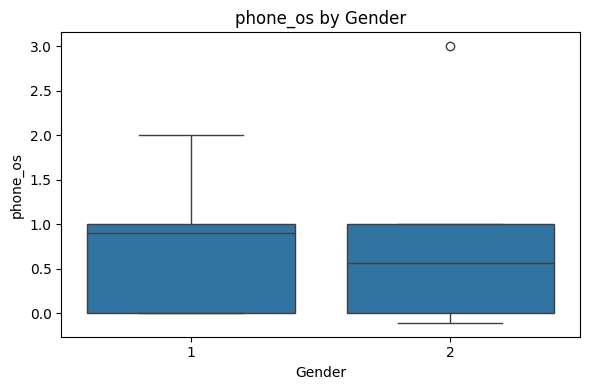

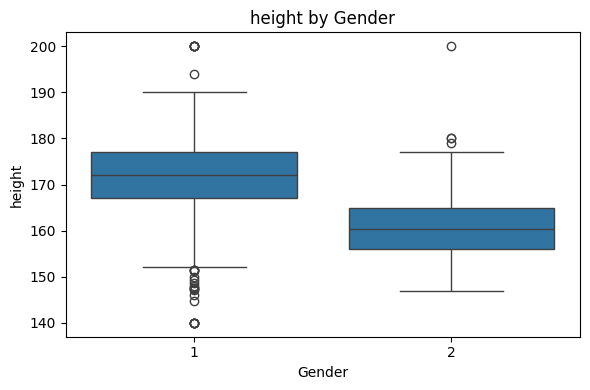

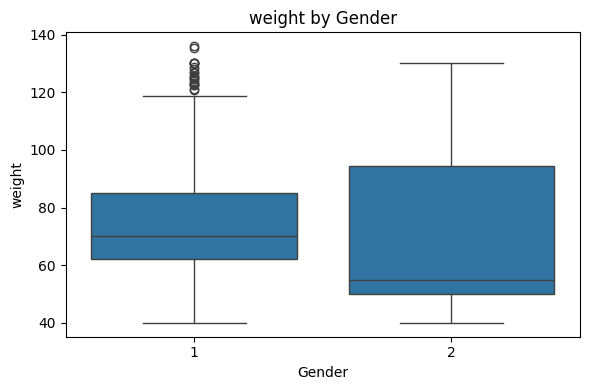

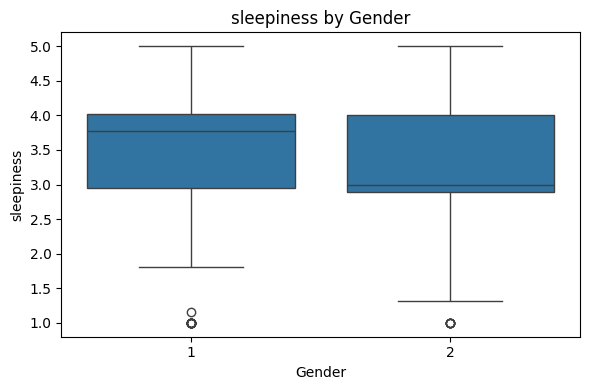

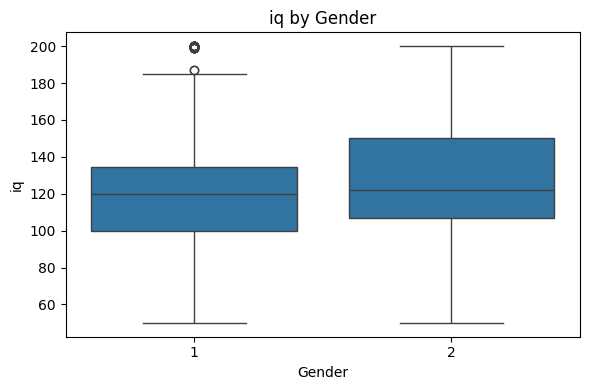

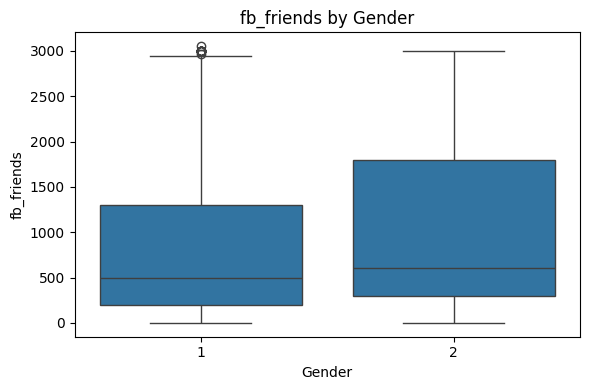

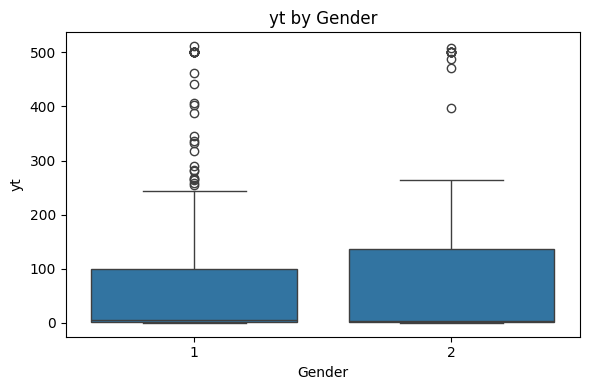

In [124]:
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=y, y=train_df_fs[col])
    plt.title(f'{col} by Gender')
    plt.xlabel("Gender")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 5.2 特徵萃取

### 5.2.1 數值型欄位萃取

In [125]:
pip install featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 14.8 MB/s eta 0:00:00


In [126]:
import featuretools as ft
from xgboost import XGBClassifier

In [127]:
def generate_feature_matrix(df, drop_cols, feature_defs=None, is_train=True):
  df_ft = df.drop(columns=drop_cols)

  # 建立 EntitySet
  es = ft.EntitySet(id='data_set')
  es.add_dataframe(dataframe_name='users', dataframe=df_ft, index='id')

  if is_train:
      # 使用 dfs 產生特徵與定義
      feature_matrix, feature_defs_out = ft.dfs(
          entityset=es,
          target_dataframe_name='users',
          trans_primitives=[
              'add_numeric',
              'subtract_numeric',
              'multiply_numeric',
              'divide_numeric',
              'percentile',
              'absolute',
              'negate'
          ],
          max_depth=1
      )
  else:
      # 使用訓練階段的特徵定義
      feature_matrix = ft.calculate_feature_matrix(
          entityset=es,
          features=feature_defs
      )
      feature_defs_out = None

  df_combined = pd.merge(df, feature_matrix, on='id', how='left')
  return df_combined, feature_defs_out

In [128]:
exclude_cols = ['phone_os','gender','sleepiness']

train_df_fs['id'] = id_train_backup
test_df_fs['id'] = id_test_backup

train_df_combined, feature_defs = generate_feature_matrix(train_df_fs, drop_cols=exclude_cols, is_train=True)
test_df_combined, _ = generate_feature_matrix(test_df_fs, drop_cols=exclude_cols, feature_defs=feature_defs, is_train=False)
train_df_combined

,gender,phone_os,height_x,weight_x,sleepiness,iq_x,fb_friends_x,yt_x,id,height_y,...,fb_friends - height,fb_friends - iq,fb_friends - weight,fb_friends - yt,height - iq,height - weight,height - yt,iq - weight,iq - yt,weight - yt
0,2,0.000000,154.0,43.0,4.071842,115.969353,583.000000,0.00000,1,154.0,...,429.000000,467.030647,540.000000,583.000000,38.030647,111.0,154.00000,72.969353,115.969353,43.00000
1,2,0.000000,156.0,47.0,2.928009,130.000000,1903.295898,3.50000,2,156.0,...,1747.295898,1773.295898,1856.295898,1899.795898,26.000000,109.0,152.50000,83.000000,126.500000,43.50000
2,1,0.793504,170.0,61.0,2.901227,90.000000,540.000000,152.76976,3,170.0,...,370.000000,450.000000,479.000000,387.230240,80.000000,109.0,17.23024,29.000000,-62.769760,-91.76976
3,1,0.000000,170.0,62.0,4.000000,100.000000,1600.708740,5.00000,4,170.0,...,1430.708740,1500.708740,1538.708740,1595.708740,70.000000,108.0,165.00000,38.000000,95.000000,57.00000
4,2,1.000000,158.0,67.0,2.968550,128.000000,320.000000,1.20000,5,158.0,...,162.000000,192.000000,253.000000,318.800000,30.000000,91.0,156.80000,61.000000,126.800000,65.80000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1,1.000000,166.0,66.0,4.000000,90.000000,1000.000000,1.00000,419,166.0,...,834.000000,910.000000,934.000000,999.000000,76.000000,100.0,165.00000,24.000000,89.000000,65.00000
419,1,1.000000,176.0,65.0,4.000000,87.000000,1300.000000,2.00000,420,176.0,...,1124.000000,1213.000000,1235.000000,1298.000000,89.000000,111.0,174.00000,22.000000,85.000000,63.00000
420,1,0.000000,174.0,72.0,2.000000,124.990738,2000.000000,9.00000,421,174.0,...,1826.000000,1875.009262,1928.000000,1991.000000,49.009262,102.0,165.00000,52.990738,115.990738,63.00000
421,2,0.071891,167.0,50.0,3.000000,180.000000,483.000000,10.00000,422,167.0,...,316.000000,303.000000,433.000000,473.000000,-13.000000,117.0,157.00000,130.000000,170.000000,40.00000


In [129]:
# 訓練集
X_train = train_df_combined.drop(columns=['id','gender'])
X_train = clean_data(X_train)

# 測試集
X_test = test_df_combined.drop(columns=['id','gender'])
X_test = clean_data(X_test)
y = train_df_fs['gender'].map({1: 0, 2: 1})

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y)

# 依據特徵重要性尋找前十重要之心特徵
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("Top 10 重要特徵：")
print(feature_importances.head(10))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 重要特徵：
height_x               0.088312
fb_friends + height    0.056129
height / weight        0.047884
fb_friends * height    0.047219
iq / height            0.046824
fb_friends * iq        0.036153
weight * yt            0.035197
fb_friends_x           0.033389
iq - weight            0.028760
iq / yt                0.025128
dtype: float32


In [130]:
top_10_features = feature_importances.head(10).index.tolist()

# 將 top_10 特徵從 feature_matrix 擷取出來
train_top_features = pd.concat([train_df_combined['id'], X_train[top_10_features]], axis=1)
test_top_features = pd.concat([test_df_combined['id'], X_test[top_10_features]], axis=1)

### 5.2.3 TF-IDF型欄位萃取

#### 前置處理

In [131]:
# drop_cols = ['phone_os', 'height', 'weight', 'sleepiness', 'iq', 'fb_friends', 'yt', 'is_outlier_fb_friends',	'is_outlier_yt', 'is_outlier_height',	'is_outlier_weight',	'is_outlier_iq']

# train_df_fe = train_df.drop(columns=drop_cols)
# test_df_fe = test_df.drop(columns=drop_cols)

# print(f"資料集筆數: {train_df_fs.shape[0]}, 特徵數量: {train_df_fs.shape[1]-1}")


In [132]:
# test_df_fe

In [133]:
# !pip install pandas numpy scikit-learn spacy
# !python -m spacy download en_core_web_md

In [134]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.ensemble import RandomForestClassifier
# import spacy
# import seaborn as sns
# import matplotlib.pyplot as plt

# X_train = train_df_fe.drop(columns=['gender'])
# y_train = train_df_fe['gender']

# X_test = test_df_fe.drop(columns=['gender'])

In [135]:
# def convert_direction(x):
#   if x > 0:
#       return '正向'
#   elif x < 0:
#       return '負向'
#   else:
#       return '無差異'

# def encode_gender_direction(df, source_col='gender_diff_2_minus_1',direction_col='gender_diff_direction',encoded_col='gender_diff_encoded'):
#     direction_order = {
#         '正向': 0,
#         '負向': 1,
#         '無差異': 2
#     }

#     # 新增方向欄位與編碼欄位
#     df[direction_col] = df[source_col].apply(convert_direction)
#     df[encoded_col] = df[direction_col].map(direction_order)

#     return df

#### 依據語意分組

In [136]:
# nlp = spacy.load('en_core_web_md')
# columns = X_train.columns.tolist()

# # 計算相似性矩陣
# similarity_matrix = np.zeros((len(columns), len(columns)))
# for i, col1 in enumerate(columns):
#     for j, col2 in enumerate(columns):
#         if i != j:
#             doc1 = nlp(col1)
#             doc2 = nlp(col2)
#             similarity_matrix[i, j] = doc1.similarity(doc2)
#         else:
#             similarity_matrix[i, j] = 1.0

# # 根據相似性閾值（0.7）群組相似的單字
# similarity_threshold = 0.7
# grouped_columns = []
# used_columns = set()
# for i, col1 in enumerate(columns):
#     if col1 in used_columns:
#         continue
#     similar_cols = [col1]
#     for j, col2 in enumerate(columns):
#         if i != j and similarity_matrix[i, j] > similarity_threshold:
#             similar_cols.append(col2)
#     grouped_columns.append(similar_cols)
#     used_columns.update(similar_cols)

# print("根據語意相似性群組的欄位：", grouped_columns)

In [137]:
# k = 50
# selector = SelectKBest(score_func=chi2, k=k)
# X_selected_chi2 = selector.fit_transform(X_train, y_train)
# selected_indices_chi2 = selector.get_support(indices=True)
# chi2_scores = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Chi2 Score': selector.scores_
# }).sort_values(by='Chi2 Score', ascending=False)

# # 從每個語意群組中選擇卡方分數最高的單字
# selected_columns_final = []
# for group in grouped_columns:
#     group_scores = chi2_scores[chi2_scores['Feature'].isin(group)]
#     if not group_scores.empty:
#         best_feature = group_scores.iloc[0]['Feature']
#         selected_columns_final.append(best_feature)

# print("\n結合語意分析後的最終選擇欄位：", selected_columns_final)

In [138]:
# # 前 10 個卡方分數
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Chi2 Score', y='Feature', data=chi2_scores.head(10))
# plt.title('Top 10 most correlated traits with gender (Chi-square scores)')
# plt.show()

In [139]:
# group_gender_diff = []
# for idx, group in enumerate(grouped_columns):
#     valid_group = [col for col in group if col in X_train.columns]
#     if valid_group:
#         group_scores = X_train[valid_group].sum(axis=1)
#         mean_gender_2 = group_scores[y_train == 2].mean() if (y_train == 2).any() else 0
#         mean_gender_1 = group_scores[y_train == 1].mean() if (y_train == 1).any() else 0
#         diff = mean_gender_2 - mean_gender_1
#         group_gender_diff.append((idx, diff))

# # 按差異值排序
# group_gender_diff = sorted(group_gender_diff, key=lambda x: x[1], reverse=True)

# # 選擇相關的群組
# k_diff_groups = 5  # 選擇前 5 個群組
# groups_gender_2 = [idx for idx, diff in group_gender_diff[:k_diff_groups]]  # 更可能與 gender 2 相關
# groups_gender_1 = [idx for idx, diff in group_gender_diff[-k_diff_groups:]]  # 更可能與 gender 1 相關

# # 創建基於群組的性別差異特徵
# def create_group_gender_diff_feature(data, grouped_columns, groups_gender_2, groups_gender_1):
#     new_features = pd.DataFrame(index=data.index)
#     # 計算與 gender 2 相關的群組分數
#     score_gender_2 = pd.Series(0, index=data.index)
#     for idx in groups_gender_2:
#         valid_group = [col for col in grouped_columns[idx] if col in data.columns]
#         if valid_group:
#             score_gender_2 += data[valid_group].sum(axis=1)
#     # 計算與 gender 1 相關的群組分數
#     score_gender_1 = pd.Series(0, index=data.index)
#     for idx in groups_gender_1:
#         valid_group = [col for col in grouped_columns[idx] if col in data.columns]
#         if valid_group:
#             score_gender_1 += data[valid_group].sum(axis=1)
#     # 計算差異
#     new_features['group_gender_diff_2_minus_1'] = score_gender_2 - score_gender_1
#     return new_features

# # 創建新特徵
# new_features_train_group_diff = create_group_gender_diff_feature(X_train, grouped_columns, groups_gender_2, groups_gender_1)
# new_features_test_group_diff = create_group_gender_diff_feature(X_test, grouped_columns, groups_gender_2, groups_gender_1)

In [140]:
# new_features_train_group_diff

In [141]:
# new_features_train_group_diff = encode_gender_direction(
#     new_features_train_group_diff,
#     source_col='group_gender_diff_2_minus_1',
#     encoded_col='gender_diff_group_encoded'
# )
# new_features_test_group_diff = encode_gender_direction(
#     new_features_test_group_diff,
#     source_col='group_gender_diff_2_minus_1',
#     encoded_col='gender_diff_group_encoded'
# )

In [142]:
# train_df['gender_group_diff_encoded'] = new_features_test_group_diff['gender_diff_group_encoded']
# test_df['gender_group_diff_encoded'] = new_features_test_group_diff['gender_diff_group_encoded']

#### 直接提取前20個相關單字

In [143]:
# gender_values = y_train.unique()
# word_gender_means = {}
# for gender in gender_values:
#     gender_mask = (y_train == gender)
#     gender_data = X_train[gender_mask]
#     word_gender_means[gender] = gender_data.mean()

# word_gender_means_df = pd.DataFrame(word_gender_means)
# word_gender_means_df.columns = [f"mean_gender_{int(g)}" for g in word_gender_means_df.columns]
# word_gender_diff = word_gender_means_df['mean_gender_2'] - word_gender_means_df['mean_gender_1']
# word_gender_diff = word_gender_diff.sort_values(ascending=False)

# print("\n單字在 gender 1 和 gender 0 間的平均 TF-IDF 分數差異（前 10 個）：")
# print(word_gender_diff.head(10))
# print("\n單字在 gender 1 和 gender 0 間的平均 TF-IDF 分數差異（後 10 個）：")
# print(word_gender_diff.tail(10))

In [144]:
# k_diff_words = 20
# words_gender_1 = word_gender_diff.head(k_diff_words).index.tolist()
# words_gender_0 = word_gender_diff.tail(k_diff_words).index.tolist()

# def create_gender_diff_feature(data, words_gender_1, words_gender_0):
#     new_features = pd.DataFrame(index=data.index)
#     valid_words_1 = [word for word in words_gender_1 if word in data.columns]
#     valid_words_0 = [word for word in words_gender_0 if word in data.columns]
#     score_gender_1 = data[valid_words_1].sum(axis=1) if valid_words_1 else pd.Series(0, index=data.index)
#     score_gender_0 = data[valid_words_0].sum(axis=1) if valid_words_0 else pd.Series(0, index=data.index)
#     new_features['gender_diff_2_minus_1'] = score_gender_1 - score_gender_0
#     return new_features

# new_features_train_gender_diff = create_gender_diff_feature(X_train, words_gender_1, words_gender_0)
# new_features_test_gender_diff = create_gender_diff_feature(X_test, words_gender_1, words_gender_0)

In [145]:
# new_features_test_gender_diff

In [146]:
# new_features_train_gender_diff = encode_gender_direction(new_features_train_gender_diff)
# new_features_test_gender_diff = encode_gender_direction(new_features_test_gender_diff)

In [147]:
# train_df['gender_diff_encoded'] = new_features_train_gender_diff['gender_diff_encoded']
# test_df['gender_diff_encoded'] = new_features_test_gender_diff['gender_diff_encoded']

## 5.3 K-Mean 分群

<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-148-63884df989c9>:40: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) miss

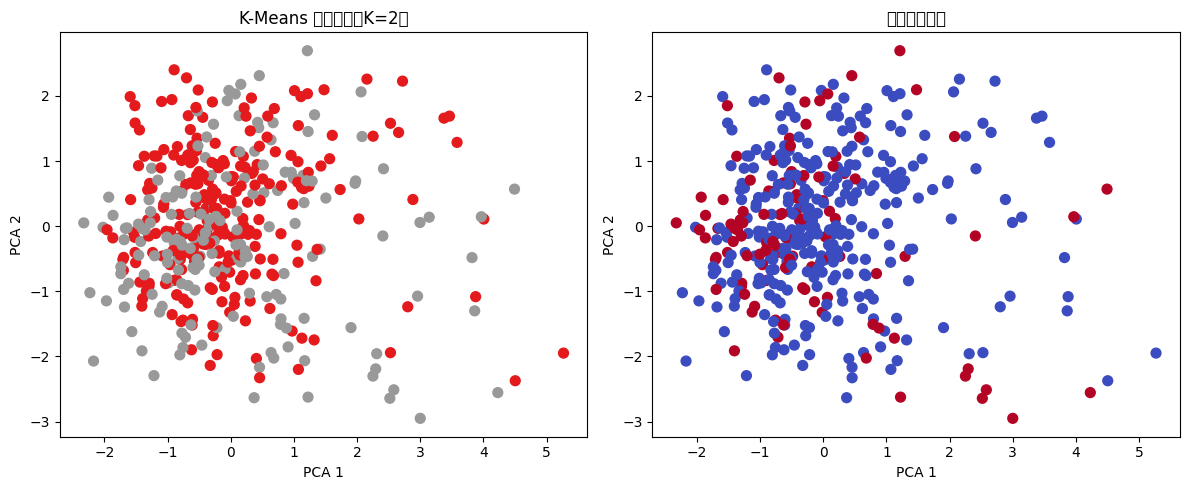

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def visualize_kmeans_with_pca(df, target_col='gender', n_clusters=2):
    df_copy = df.copy()

    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    # 標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 建立 KMeans 模型並分群
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    X_pca = PCA(n_components=2).fit_transform(X_scaled) # 降維

    # KMeans 分群結果
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', s=50)
    plt.title(f"K-Means 分群結果（K={n_clusters}）")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    # 真實分布
    plt.subplot(1, 2, 2)
    gender_numeric = y.astype('category').cat.codes
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gender_numeric, cmap='coolwarm', s=50)
    plt.title("實際性別分布")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    plt.tight_layout()
    plt.show()

    result_df = X.copy()
    result_df['cluster'] = clusters
    result_df['pca1'] = X_pca[:, 0]
    result_df['pca2'] = X_pca[:, 1]

    return clusters, X_pca, result_df

clusters, pca_result, result_df = visualize_kmeans_with_pca(train_df_fs)

In [149]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_iris

X = train_df_fs.drop(columns=['gender'])
y = train_df_fs['gender']

# 降維
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

print("降維後的數據形狀:", X_lda.shape)
print(result_df['cluster'].value_counts())

降維後的數據形狀: (423, 1)
cluster
0    251
1    172
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas

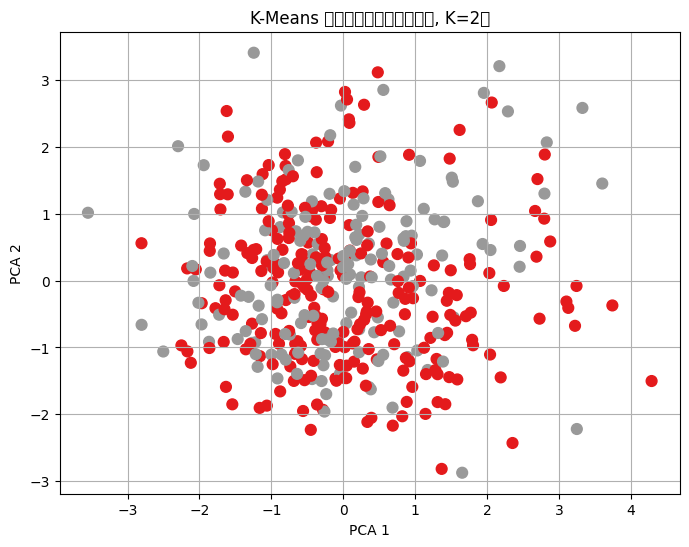

cluster
0    254
1    172
Name: count, dtype: int64


In [150]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def kmeans_all_features_plot(df, n_clusters=2):
    df = df.drop(columns=['gender'])
    # 取數值欄位
    X = df.select_dtypes(include=['float64', 'int64']).dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # 降維
    X_pca = PCA(n_components=2).fit_transform(X_scaled)

    # 顯示分群結果
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', s=60)
    plt.title(f"K-Means 分群結果（使用所有特徵, K={n_clusters}）")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

    result_df = X.copy()
    result_df['cluster'] = clusters
    result_df['pca1'] = X_pca[:, 0]
    result_df['pca2'] = X_pca[:, 1]

    return clusters, result_df

clusters, result_df = kmeans_all_features_plot(test_df_fs, n_clusters=2)
print(result_df['cluster'].value_counts())

## 5.4 刪除+新增欄位

In [151]:
train_df['id'] = id_train_backup
test_df['id'] = id_test_backup

# 加回到原始 train/test 資料表中
train_df = pd.merge(train_df, train_top_features, on='id', how='left')
test_df = pd.merge(test_df, test_top_features, on='id', how='left')

train_df_fs = pd.merge(train_df_fs, train_top_features, on='id', how='left')
test_df_fs = pd.merge(test_df_fs, test_top_features, on='id', how='left')

train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)

In [152]:
train_df.drop(columns=['yt', 'fb_friends'], inplace=True)
test_df.drop(columns=['yt', 'fb_friends'], inplace=True)

In [153]:
test_df

,gender,phone_os,height,weight,sleepiness,iq,is_outlier_fb_friends,is_outlier_yt,is_outlier_height,is_outlier_weight,...,height_x,fb_friends + height,height / weight,fb_friends * height,iq / height,fb_friends * iq,weight * yt,fb_friends_x,iq - weight,iq / yt
0,NaN,0.000000,200.0,100.000000,1.000000,87.000000,0,1,1,1,...,200.0,287.000000,2.000000,17400.000000,0.435000,7569.000000,8700.000000,87.000000,-13.000000,1.000000
1,NaN,0.000000,175.0,80.000000,3.000000,140.788818,1,1,0,0,...,175.0,2175.000000,2.187500,350000.000000,0.804508,281577.636719,19753.133545,2000.000000,60.788818,0.570193
2,NaN,0.000000,155.0,45.000000,3.000000,150.000000,1,0,0,0,...,155.0,2193.108887,3.444444,315906.877441,0.967742,305716.333008,405.000000,2038.108887,105.000000,16.666667
3,NaN,0.000000,173.0,85.000000,4.000000,137.401123,1,0,0,0,...,173.0,2454.253174,2.035294,394656.799072,0.794226,313446.748038,1275.000000,2281.253174,52.401123,9.160075
4,NaN,1.000000,164.0,57.000000,4.000000,130.000000,0,0,0,0,...,164.0,669.000000,2.877193,82820.000000,0.792683,65650.000000,114.000000,505.000000,73.000000,65.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,0.000000,160.0,70.000000,4.000000,125.273056,0,0,0,0,...,160.0,660.000000,2.285714,80000.000000,0.782957,62636.528015,350.000000,500.000000,55.273056,25.054611
422,NaN,1.000000,162.0,54.000000,3.000000,180.000000,0,0,0,0,...,162.0,624.000000,3.000000,74844.000000,1.111111,83160.000000,270.000000,462.000000,126.000000,36.000000
423,NaN,0.000000,173.0,66.000000,3.342718,135.000000,0,0,0,0,...,173.0,275.000000,2.621212,17646.000000,0.780347,13770.000000,732.600000,102.000000,69.000000,12.162162
424,NaN,0.357246,165.0,53.000000,3.912219,110.000000,0,1,0,0,...,165.0,672.000000,3.113208,83655.000000,0.666667,55770.000000,22048.000000,507.000000,57.000000,0.264423


# **6. 資料不平衡處理**

## 6.1 SMOTE

In [154]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# 定義 SMOTE 處理函數
def apply_smote(X, y, random_state=42):
    # 處理無窮大和 NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True))
    # 標籤轉為 0 和 1
    y_encoded = y - 1 # gender: 1/2 → 0/1
    # SMOTE 重抽樣
    smote = SMOTE(random_state=random_state)
    X_smote, y_smote = smote.fit_resample(X, y_encoded)
    print("SMOTE 後分佈：", Counter(y_smote))
    return X_smote, y_smote


# 特徵與標籤切分
X = train_df.drop(columns=['gender']).astype(float)
y = train_df['gender']
X_smote, y_smote = apply_smote(X, y, random_state=42)

SMOTE 後分佈： Counter({1: 316, 0: 316})


## 6.1SMOTENN

In [155]:
# from imblearn.combine import SMOTEENN
# from collections import Counter
# import numpy as np

# # 定義 SMOTEENN 處理函數
# def apply_smotenn(X, y, random_state=42):
#     # 處理無窮大和 NaN
#     X = X.replace([np.inf, -np.inf], np.nan)
#     X = X.fillna(X.median(numeric_only=True))

#     # 標籤轉為 0 和 1
#     y_encoded = y - 1  # gender: 1/2 → 0/1

#     # SMOTEENN 重抽樣
#     smotenn = SMOTEENN(random_state=random_state)
#     X_resampled, y_resampled = smotenn.fit_resample(X, y_encoded)

#     print("SMOTEENN 後分佈：", Counter(y_resampled))
#     return X_resampled, y_resampled

# # 特徵與標籤切分
# X = train_df.drop(columns=['gender']).astype(float)
# y = train_df['gender']
# X_smotenn, y_smotenn = apply_smotenn(X, y, random_state=42)


## 6.1 Smote+Tomek

In [156]:
# from imblearn.combine import SMOTETomek
# from collections import Counter
# import numpy as np

# # 定義 SMOTE+Tomek 處理函數
# def apply_smote_tomek(X, y, random_state=42):
#     # 處理無窮大和 NaN
#     X = X.replace([np.inf, -np.inf], np.nan)
#     X = X.fillna(X.median(numeric_only=True))

#     # 標籤轉為 0 和 1（假設 gender 是 1/2）
#     y_encoded = y - 1

#     # SMOTE + Tomek Links 重抽樣
#     smote_tomek = SMOTETomek(random_state=random_state)
#     X_resampled, y_resampled = smote_tomek.fit_resample(X, y_encoded)

#     print("SMOTE + Tomek Links 後分佈：", Counter(y_resampled))
#     return X_resampled, y_resampled

# # 特徵與標籤切分
# X = train_df.drop(columns=['gender']).astype(float)
# y = train_df['gender']

# # 套用 SMOTE+Tomek
# X_smote_tomek, y_smote_tomek = apply_smote_tomek(X, y, random_state=42)

# **7. 預測分類模型**


## 7.1 XGBOOST

In [157]:
'''
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 定義參數網格
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# 建立基礎模型
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,  # 防止警告
    random_state=42
)

# 建立 GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',  # 或 'f1', 'roc_auc' 等
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 執行搜尋
grid_search_xgb.fit(X_smote, y_smote)

# 顯示最佳參數與分數
print("最佳參數：", grid_search_xgb.best_params_)
print("最佳交叉驗證分數：", grid_search_xgb.best_score_)

# 取得最佳模型
xg_clf = grid_search_xgb.best_estimator_
'''

from xgboost import XGBClassifier
#  建立模型
xg_clf = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
#    scale_pos_weight=2.04,  # 調整少數類權重
    eval_metric='logloss',
    random_state=42
)

# 模型訓練
xg_clf.fit(X_smote, y_smote)


# X_test = test_df.drop(columns=['gender']).astype(float)

# 轉回原本的 1/2 標籤
# y_test_pred = xg_clf.predict(X_test) + 1


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [158]:
print("Train 欄位缺失情況：")
print(train_df.isna().sum())

print("\nTest 欄位缺失情況：")
print(test_df.isna().sum())

Train 欄位缺失情況：
gender             0
phone_os           0
height             0
weight             0
sleepiness         0
                  ..
fb_friends * iq    0
weight * yt        0
fb_friends_x       0
iq - weight        0
iq / yt            0
Length: 121, dtype: int64

Test 欄位缺失情況：
gender             426
phone_os             0
height               0
weight               0
sleepiness           0
                  ... 
fb_friends * iq      0
weight * yt          0
fb_friends_x         0
iq - weight          0
iq / yt              0
Length: 121, dtype: int64


## 7.2 Random forest

In [159]:
'''
from sklearn.model_selection import GridSearchCV

# 定義參數網格（你可以調整或擴充）
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# 建立模型
rf_clf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# 建立 GridSearchCV 物件
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# 執行網格搜尋
grid_search.fit(X_smote, y_smote)

# 最佳模型與參數
print("最佳參數組合：", grid_search.best_params_)
print("最佳交叉驗證分數：", grid_search.best_score_)

# 取出最佳模型
rf_clf = grid_search.best_estimator_

'''
from sklearn.ensemble import RandomForestClassifier

# 建立模型
rf_clf = RandomForestClassifier(
    n_estimators=200,      # 樹的數量
    max_depth=10,
#    class_weight='balanced',
    min_samples_split=5,   # 控制每個節點分裂的最小樣本數
    min_samples_leaf=2,    # 葉節點最小樣本數
    max_features='sqrt',   # 特徵子集選擇
    criterion='gini',
    random_state=42,       # 保持隨機種子一致性
    n_jobs=-1
)

# 模型訓練
rf_clf.fit(X_smote, y_smote)



# X_test = test_df.drop(columns=['gender']).astype(float)
# X_test = clean_data(X_test)

# # 轉回原本的 1/2 標籤
# y_test_pred = rf_clf.predict(X_test)+1

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [160]:
# test_df['gender'] = y_test_pred

In [161]:
# test_df

In [162]:
# gender_counts = test_df['gender'].value_counts(dropna=False)
# gender_counts

## 7.3 Light GBM

In [163]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import warnings
'''
# 建立基礎模型
lgb_base = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

# 建立參數網格
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9],
    'min_child_samples': [5, 10],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [15, 20, 31]
}

# 建立 GridSearchCV
grid_search_lgb = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 執行 Grid Search，搭配忽略警告訊息
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    grid_search_lgb.fit(X_smote, y_smote)

# 顯示最佳參數與分數
print("最佳參數組合：", grid_search_lgb.best_params_)
print("最佳交叉驗證分數：", grid_search_lgb.best_score_)

# 最佳模型
lgb_base = grid_search_lgb.best_estimator_
'''

# from lightgbm import LGBMClassifier
import warnings
lgb_base = LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    min_child_samples=5,
    learning_rate=0.1,     # 學習率
    num_leaves=20,
    random_state=42,
    n_jobs=-1
)
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=UserWarning)  # 忽略特定警告訊息
  lgb_base.fit(X_smote, y_smote)
# X_test = test_df.drop(columns=['gender']).astype(float)
# X_test = clean_data(X_test)

# # 預測結果：轉回原本的 1/2 標籤
# y_test_pred = lgb_base.predict(X_test) + 1
# test_df['gender'] = y_test_pred

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316, number of negative: 316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3285
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [164]:
# gender_counts = test_df['gender'].value_counts(dropna=False)
# gender_counts

## 7.4 Stack

In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

'''
# 定義 base estimators
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
]

# 建立 StackingClassifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# 建立參數網格
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators': [100, 200],
    'final_estimator__C': [0.1, 1, 10]  # LogisticRegression 的參數
}

# 套用 GridSearch
grid_search_stack = GridSearchCV(
    estimator=stack_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 執行搜尋
grid_search_stack.fit(X_smote, y_smote)

# 顯示結果
print("最佳參數：", grid_search_stack.best_params_)
print("最佳交叉驗證分數：", grid_search_stack.best_score_)

# 最佳模型
stack_clf = grid_search_stack.best_estimator_
'''

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
estimators = [
    ('rf', rf_clf),
    ('xgb', xg_clf)
]
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# 模型訓練
stack_clf.fit(X_smote, y_smote)

X_test = test_df.drop(columns=['gender']).astype(float)
X_test = clean_data(X_test)

# 轉回原本的 1/2 標籤
y_test_pred = stack_clf.predict(X_test) + 1

In [166]:
test_df['gender'] = y_test_pred
test_df

,gender,phone_os,height,weight,sleepiness,iq,is_outlier_fb_friends,is_outlier_yt,is_outlier_height,is_outlier_weight,...,height_x,fb_friends + height,height / weight,fb_friends * height,iq / height,fb_friends * iq,weight * yt,fb_friends_x,iq - weight,iq / yt
0,1,0.000000,200.0,100.000000,1.000000,87.000000,0,1,1,1,...,200.0,287.000000,2.000000,17400.000000,0.435000,7569.000000,8700.000000,87.000000,-13.000000,1.000000
1,1,0.000000,175.0,80.000000,3.000000,140.788818,1,1,0,0,...,175.0,2175.000000,2.187500,350000.000000,0.804508,281577.636719,19753.133545,2000.000000,60.788818,0.570193
2,2,0.000000,155.0,45.000000,3.000000,150.000000,1,0,0,0,...,155.0,2193.108887,3.444444,315906.877441,0.967742,305716.333008,405.000000,2038.108887,105.000000,16.666667
3,1,0.000000,173.0,85.000000,4.000000,137.401123,1,0,0,0,...,173.0,2454.253174,2.035294,394656.799072,0.794226,313446.748038,1275.000000,2281.253174,52.401123,9.160075
4,1,1.000000,164.0,57.000000,4.000000,130.000000,0,0,0,0,...,164.0,669.000000,2.877193,82820.000000,0.792683,65650.000000,114.000000,505.000000,73.000000,65.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2,0.000000,160.0,70.000000,4.000000,125.273056,0,0,0,0,...,160.0,660.000000,2.285714,80000.000000,0.782957,62636.528015,350.000000,500.000000,55.273056,25.054611
422,2,1.000000,162.0,54.000000,3.000000,180.000000,0,0,0,0,...,162.0,624.000000,3.000000,74844.000000,1.111111,83160.000000,270.000000,462.000000,126.000000,36.000000
423,1,0.000000,173.0,66.000000,3.342718,135.000000,0,0,0,0,...,173.0,275.000000,2.621212,17646.000000,0.780347,13770.000000,732.600000,102.000000,69.000000,12.162162
424,2,0.357246,165.0,53.000000,3.912219,110.000000,0,1,0,0,...,165.0,672.000000,3.113208,83655.000000,0.666667,55770.000000,22048.000000,507.000000,57.000000,0.264423


In [167]:
gender_counts = test_df['gender'].value_counts(dropna=False)
gender_counts

,count
gender,
1,302
2,124


In [174]:
import datetime
from google.colab import files
test_df['gender'] = test_df['gender'].astype('int64')
today_str = (datetime.datetime.utcnow() + datetime.timedelta(hours=8)).strftime('%m%d')
filename = f'{today_str}_ALLColumnxg_stack.csv'

submit_df = pd.DataFrame({
    "id": range(1, len(test_df)+1),
    "gender": test_df["gender"]
})
# submit_df.to_csv("my_data.csv", index=False)
# files.download("my_data.csv")
# # 直接儲存到 Google 雲端硬碟的路徑
submit_df.to_csv(f'drive/My Drive/Colab Notebooks/datasets/{filename}', index=False)

print("檔案已成功儲存到 Google 雲端硬碟！")

檔案已成功儲存到 Google 雲端硬碟！


## 7.5 模型交叉驗證

In [169]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 定義交叉驗證函數
def run_cross_validation(X, y, model, use_smote=True, cv=5, random_state=42):
    '''
    傳入參數:
    X: 特徵數據
    y: 標籤數據 (1/2)
    model: 要評估的模型
    use_smote: 是否在交叉驗證中使用 SMOTE (True:用Pipeline ；False:直接用原始數據)
    cv: 交叉驗證折數，預設為 5
    random_state: 隨機種子

    '''

    # 清理數據
    X_clean = clean_data(X)
    # 調整標籤為 0/1
    y_adjusted = y - 1

    # 定義 StratifiedKFold，維持相同性別比
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    # 根據 use_smote 選擇是否使用 Pipeline
    if use_smote:
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=random_state)),
            ('classifier', model)
        ])
        estimator = pipeline
    else:
        estimator = model


    # 計算各評估指標
    metrics = {
        'accuracy': cross_val_score(estimator, X_clean, y_adjusted, cv=skf, scoring='accuracy'),
        'precision': cross_val_score(estimator, X_clean, y_adjusted, cv=skf, scoring='precision'),
        'recall': cross_val_score(estimator, X_clean, y_adjusted, cv=skf, scoring='recall'),
        'f1': cross_val_score(estimator, X_clean, y_adjusted, cv=skf, scoring='f1'),
        'roc_auc': cross_val_score(estimator, X_clean, y_adjusted, cv=skf, scoring='roc_auc')
    }

    # 輸出結果
    print(f"\n{model}\n五折交叉驗證評估指標（use_smote={use_smote}）：")
    for metric, scores in metrics.items():
        print(f"{metric}: 平均 = {np.mean(scores):.4f}, 每折 = {scores}")

    return metrics


In [170]:
metrics_smote = run_cross_validation(X, y, rf_clf, use_smote=True)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)
五折交叉驗證評估指標（use_smote=True）：
accuracy: 平均 = 0.8487, 每折 = [0.88235294 0.88235294 0.76470588 0.79761905 0.91666667]
precision: 平均 = 0.7045, 每折 = [0.77272727 0.75       0.52       0.59090909 0.88888889]
recall: 平均 = 0.7182, 每折 = [0.77272727 0.81818182 0.61904762 0.61904762 0.76190476]
f1: 平均 = 0.7091, 每折 = [0.77272727 0.7826087  0.56521739 0.60465116 0.82051282]
roc_auc: 平均 = 0.9081, 每折 = [0.94949495 0.96176046 0.78422619 0.88208617 0.96296296]


In [171]:
metrics_smote = run_cross_validation(X, y, xg_clf, use_smote=True)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
五折交叉驗證評估指標（use_smote=True）：
accuracy: 平均 = 0.8889, 每折 = [0.89411765 0.94117647 0.82352941 0.85714286 0.92857143]
precision: 平均 = 0.7616, 每折 = [0.76       0.84       0.63636364 0.71428571 0.85714286]
recall: 平均 = 0.8113, 每折 = [0.86363636 0.9545

In [172]:
metrics_smote = run_cross_validation(X, y, lgb_base, use_smote=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 253, number of negative: 253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 506, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 253, number of negative: 253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 506, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500

In [173]:
metrics_smote = run_cross_validation(X, y, stack_clf, use_smote=True)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stoppi